# House Prices Regression


# Data

In [1]:
import time
from datetime import datetime
#measure notebook running time
start_time = time.time()

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# backbone
import numpy as np 
from numpy.random import seed
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge,LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgb

from category_encoders import MEstimateEncoder

sns.set(style='darkgrid', context='notebook', palette='deep', rc={'figure.figsize':(10,8)})

In [2]:
mm = StandardScaler()

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train['Set'] = "Train"
test['Set'] = "test"
test['SalePrice'] = -1
df = pd.concat([train, test], ignore_index=True)
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

## Drop Outliers

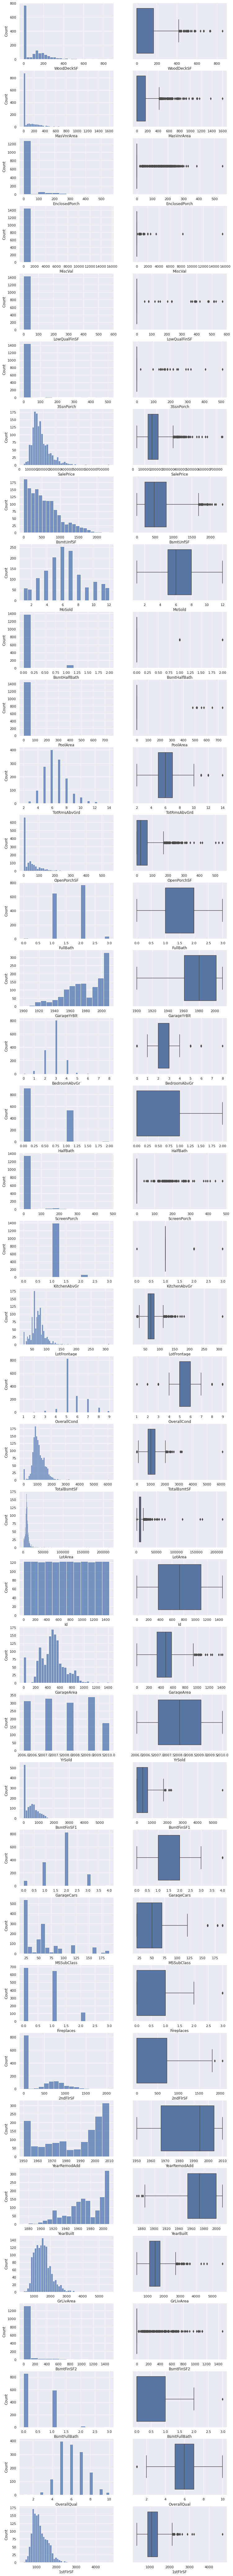

In [4]:
# 找到所有数字类型特征(numeric feature)
num_features = train.select_dtypes(exclude='object').columns
cur_features = df.columns
num_features = list(set(num_features)&set(cur_features))

# 对于每个特征，用histogram和boxplot可视化
n = len(num_features)
fig = plt.figure(figsize=(6*2, 4*n))
gs = fig.add_gridspec(n, 2) 
ax = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(n)]

for i in range(n):
    sns.histplot(x=num_features[i], data=train, ax=ax[i][0])
    sns.boxplot(x=num_features[i], data=train, ax=ax[i][1])
    
plt.show()

drop outlier，下面的cell尝试过多种选择，但是只舍弃GrLivArea>4000的评分最好，其余尝试过的类型都被注释掉了

In [5]:
df = df.drop(df[df.Set == "Train"][df[df.Set == "Train"]['GrLivArea'] > 4000].index)
# df = df.drop(df[df.Set == "Train"][df[df.Set == "Train"]['MasVnrArea'] > 1400].index)
# df = df.drop(df[df.Set == "Train"][df[df.Set == "Train"]['BsmtFinSF1'] > 5000].index)
# df = df.drop(df[df.Set == "Train"][df[df.Set == "Train"]['LotFrontage'] > 300].index)
# df = df.drop(df[df.Set == "Train"][df[df.Set == "Train"]['TotalBsmtSF'] > 5000].index)
# df = df.drop(df[df.Set == "Train"][df[df.Set == "Train"]['LotArea'] > 200000].index)
df.reset_index(inplace=True, drop = True)

## Missing data

In [6]:
# 找出有缺失值的列
missing_col = df.columns[df.isnull().any()]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_col)

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')


<AxesSubplot:>

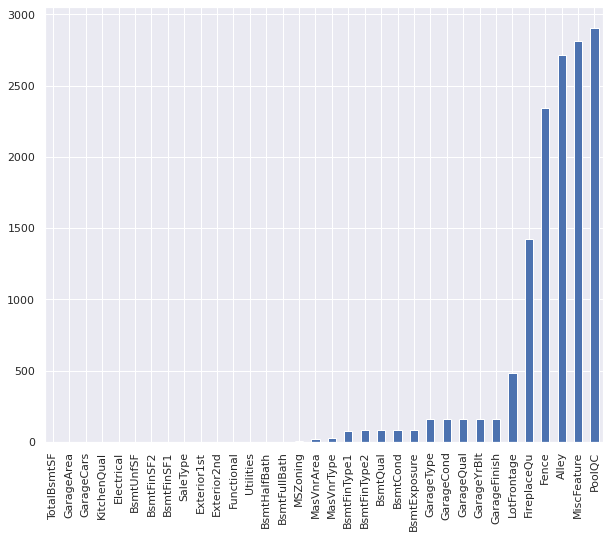

In [7]:
df[df.columns[df.isna().sum() > 0]].isna().sum().sort_values().plot.bar()

## Fill NA

填充na分为两部分: 
- 有一部分特征出现na是因为在该样本上，与该特征有联系的另一特征取值为0，比如一个没有basement的样本, BsmtCond就为Na
- 还有一部分特征的值缺失是真的缺失，但经过排查，发现这些缺失值都出现在test set中

下述特征都属于第一种情况，因此直接把NA用有含义的值来代替即可：

In [8]:
df.Alley.fillna("NO", inplace = True)
df.BsmtCond.fillna("No", inplace=True)
df.BsmtQual.fillna("No", inplace=True)
df.BsmtExposure.fillna("NB", inplace=True)
df.BsmtFinType1.fillna("NB", inplace=True)
df.BsmtFinType2.fillna("NB", inplace=True)
df.BsmtFinSF1.fillna(0., inplace=True)
df.BsmtFinSF2.fillna(0., inplace=True)
df.BsmtUnfSF.fillna(0., inplace=True)
df.TotalBsmtSF.fillna(0., inplace=True)

df.FireplaceQu.fillna("No", inplace = True)
df.GarageType.fillna("No", inplace = True)
df.GarageYrBlt.fillna(0, inplace = True)
df.GarageFinish.fillna("No", inplace = True)
df.GarageCars.fillna(0, inplace = True)
df.GarageArea.fillna(0, inplace = True)
df.GarageQual.fillna("No", inplace = True)
df.GarageCond.fillna("No", inplace = True)
df.PoolQC.fillna("No", inplace = True)
df.Fence.fillna("No", inplace = True)
df.MiscFeature.fillna("No", inplace = True)
df.SaleType.fillna("Con", inplace = True)


对于以下特征，经过对数据集的观察和官方description.txt中的描述发现：其特点是na只出现在test set，并且na代表数据缺失，并非像上面cell中na数据有“无”的特殊含义，因此这里采用将取值最多的类别作为填充的策略。

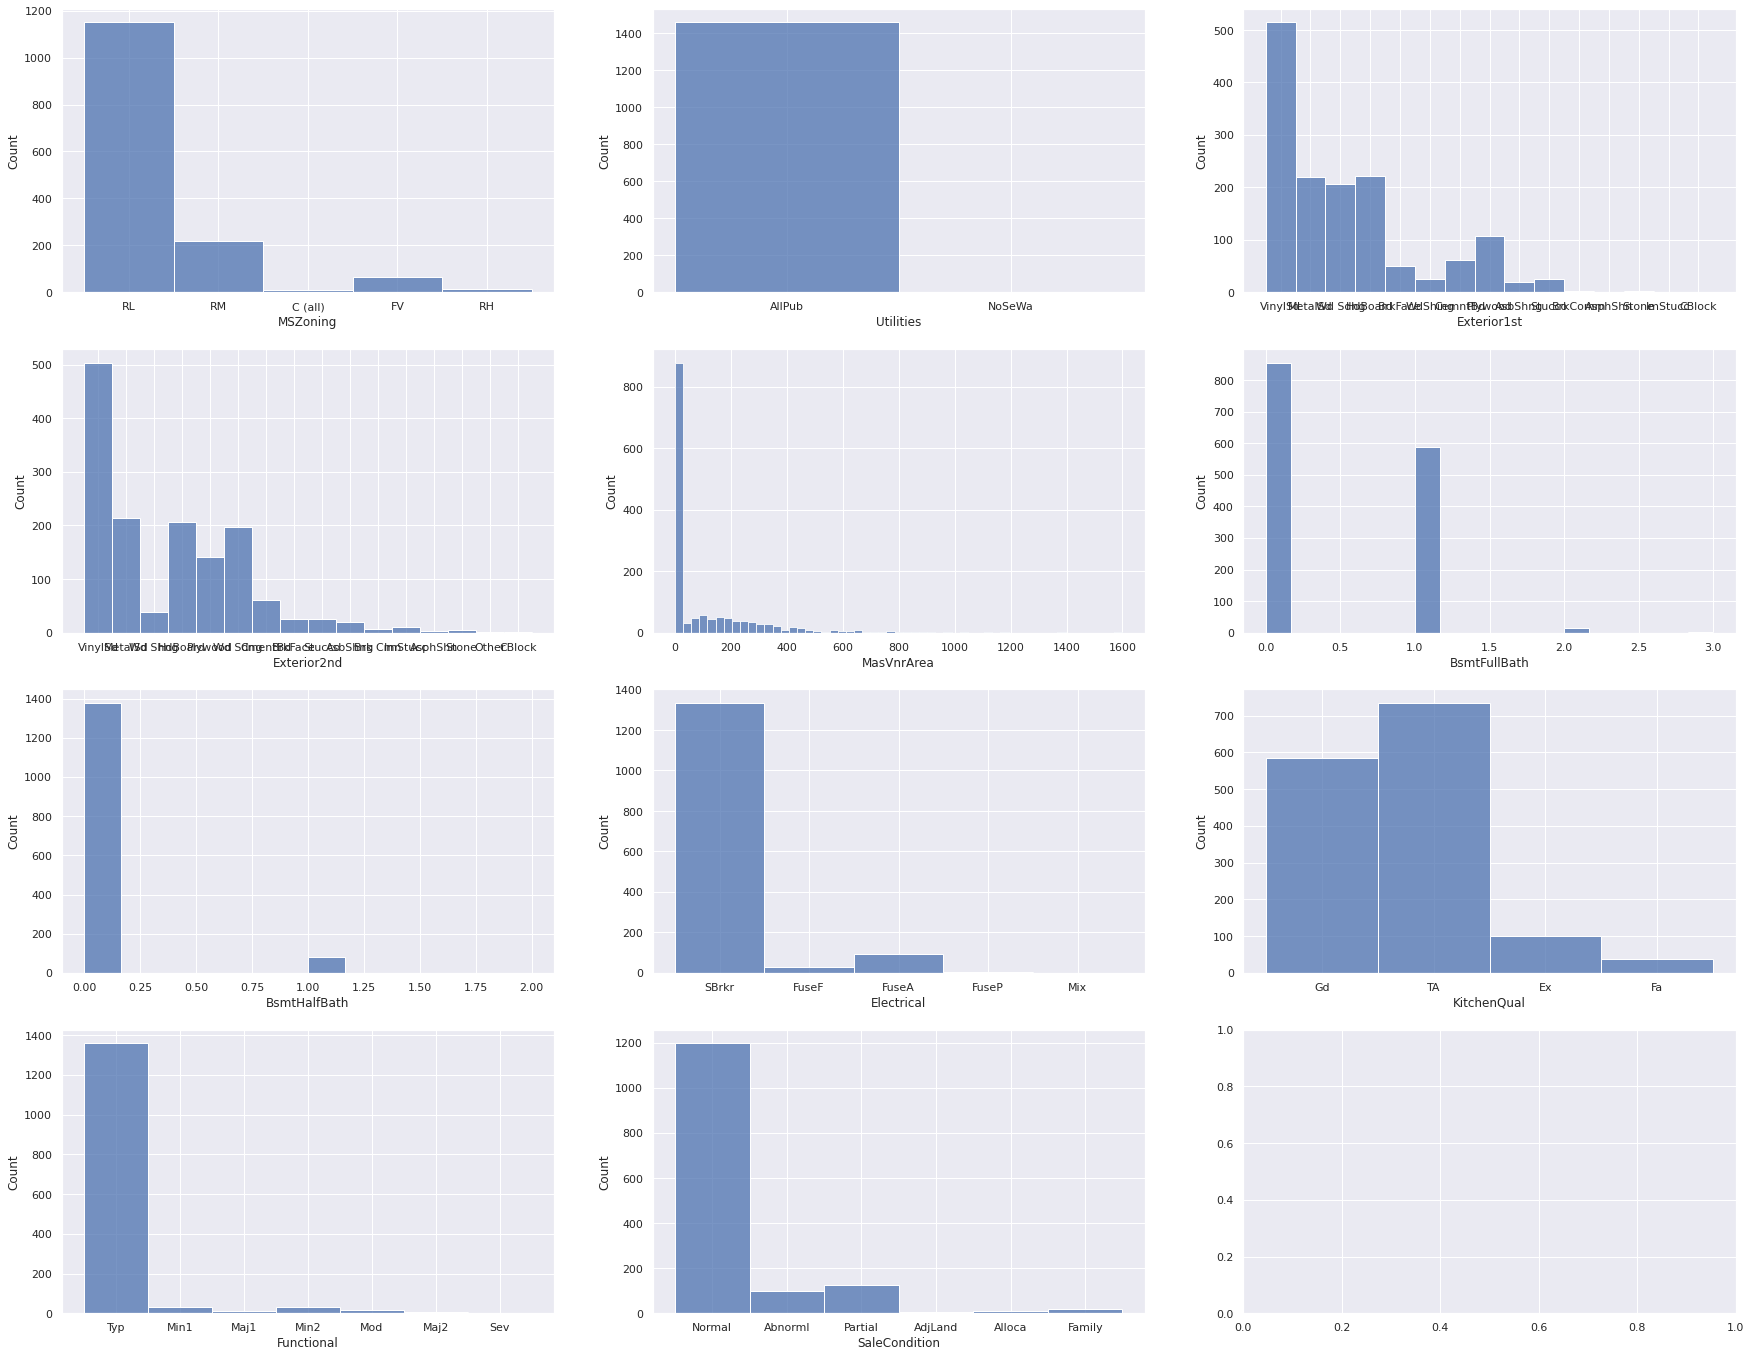

In [9]:
# 经过逐个排查确定剩余的11个未填充的特征
na_features = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath',\
                'Electrical', 'KitchenQual', 'Functional', 'SaleCondition']

n = len(na_features)
n_col = 3
n_row = int(np.ceil(n/n_col))

fig = plt.figure(figsize=(n_col*10, n_row*6))
gs = fig.add_gridspec(n_row, n_col)
ax = [[fig.add_subplot(gs[i,j]) for j in range(n_col)] for i in range(n_row)]

for i in range(n_row):
    for j in range(n_col):
        if n_col*i+j < n:
            sns.histplot(x=na_features[n_col*i+j], data=train, ax=ax[i][j])
    
plt.show()

In [10]:
# 所有仅在test set中有na缺失的特征
df['MSZoning'].fillna("RL", inplace = True)
df.Utilities.fillna('AllPub',inplace = True)
df.Exterior1st.fillna("VinylSd", inplace = True)
df.Exterior2nd.fillna("VinylSd", inplace = True)
df.MasVnrArea.fillna(0., inplace=True)  # 由MasVnrType决定，只出现在test set
df.BsmtFullBath.fillna(0., inplace=True) 
df.BsmtHalfBath.fillna(0., inplace=True)
df.Electrical.fillna("SBrkr", inplace = True)
df.KitchenQual.fillna("TA", inplace = True) 
df.Functional.fillna('Typ', inplace = True) 
df.SaleCondition.fillna("Normal", inplace = True)

## Feature Eng

以LotFrontage为例：<br>
LotFrontage: Linear feet of street connected to property<br>
根据上述其含义，通过neighborhood和street进行分组

In [11]:
df['LotFrontage'] = df.groupby(['Neighborhood', 'Street'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [12]:
df.BsmtFullBath.replace(3.0, 2.0, inplace=True)
df.BsmtFullBath = df.BsmtFullBath.astype('int')
df.BsmtHalfBath = df.BsmtHalfBath.astype('int')
df.KitchenAbvGr = pd.cut(df.KitchenAbvGr,2)
df.KitchenAbvGr = df.KitchenAbvGr.astype('category').cat.rename_categories([0, 1])
# 把Fireplaces多于2的全部归为2
df.Fireplaces = df.Fireplaces.apply(lambda row: 2 if row >= 2 else row)
df.Fireplaces = df.Fireplaces.astype('int')
# 新建特征表示garage建造时间远近
df['GarageAgeCat'] = df.GarageYrBlt.apply(lambda row: 'recent' if row >= 2000 else 'old') 
df.GarageCars = df.GarageCars.astype('int')

In [13]:
# 许多quality或condition特征共享取值范围，将其把categorical feature转为numeric feature
marks = {"No":0, "Po": 1, 'Fa': 2, "TA": 3, 'Gd': 4, 'Ex': 5}

def mark_to_num(mark):
    return marks[mark]

df['ExterQual'] = df['ExterQual'].apply(mark_to_num)
df['ExterCond'] = df['ExterCond'].apply(mark_to_num)
df['HeatingQC'] = df['HeatingQC'].apply(mark_to_num)
df['KitchenQual'] = df['KitchenQual'].apply(mark_to_num)
df['FireplaceQu'] = df['FireplaceQu'].apply(mark_to_num)
df['GarageQual'] = df['GarageQual'].apply(mark_to_num)
df['GarageCond'] = df['GarageCond'].apply(mark_to_num)
df['PoolQC'] = df['PoolQC'].apply(mark_to_num)
df['BsmtCond'] = df['BsmtCond'].apply(mark_to_num)
df['BsmtQual'] = df['BsmtQual'].apply(mark_to_num)

以下建造新特征，主要包含以下若干情况：<br>
- 加法：计算同一物件的总出现次数作为新特征（如porch，计算出某条样本的porch总数作为特征)
- 乘法：对于可以量化的类型特征，用乘法进行构造新特征，如ExterQual是明显的
- 减法：用于年限的计算，如GarageAge
- WOW相关：WOW factor，其含义是用确定的quality特征(一般为categorical feature)与相关的面积特征(numeric feature)做相乘运算
<br>另外，对一些含样本数较少的特征取值进行了重新分类和归并

In [14]:
df['BsmtFinSF'] = df.BsmtFinSF1 + df.BsmtFinSF2
df['Porch'] = df.ScreenPorch + df.EnclosedPorch + df.OpenPorchSF + df.WoodDeckSF + df['3SsnPorch']
df['Total_surface'] = df.TotalBsmtSF + df['1stFlrSF'] + df['2ndFlrSF']
df['Age'] = df.YrSold - df.YearBuilt
df['RemodAge'] = df.YrSold - df.YearRemodAdd
df['GarageAge'] = df.YrSold - df.GarageYrBlt
df['Overall'] = df['OverallCond'] * df.OverallQual
df['Exterior_Overall'] = df['ExterCond'] * df['ExterQual']
df['LotArea_log'] = np.log(df['LotArea'])
df["Spaciousness"] = (df['1stFlrSF'] + df['2ndFlrSF']) / df.TotRmsAbvGrd
df['Porch_types'] = df[['ScreenPorch', 'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', '3SsnPorch']].gt(0.0).sum(axis=1)
df['WOW'] = np.sqrt(df['Overall'] * df['GrLivArea']) 
df["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
df['GarageOverall'] = df.GarageQual * df.GarageCond
df['GarageWow'] = df.GarageOverall * df.GarageArea
df['Newness'] = np.sqrt(df.YearRemodAdd * df.GrLivArea)
df['New'] = df.Age.apply(lambda row: 1 if row == 0 else 0)
df['BsmtWow'] = df.BsmtCond * df.BsmtFinSF #not used
df['Freshness'] = df.Age * df.RemodAge #not used
df['Grand_Total'] = df.GrLivArea * 0.55 + df.GarageArea * 0.55 + df.BsmtFinSF * 0.4 + df.Porch * 0.5 #not used
df['Fresh'] = df.RemodAge.apply(lambda row: 1 if row == 0 else 0) #not used
df['MSZ_Age'] =(df.groupby(['MSZoning'])['Age'].transform(lambda x: x.median()) + df.Age)/2 #not used

In [15]:
check = sorted(["Grand_Total","Newness", "MedNhbdArea","WOW","LotArea_log",'Total_surface','BsmtFinSF','Porch',"Spaciousness", "Age", 'Freshness','GarageOverall'])

以salecondion作为类区分，画check中特征和saleprice的散点图

CPU times: user 4.24 s, sys: 252 ms, total: 4.49 s
Wall time: 4.13 s


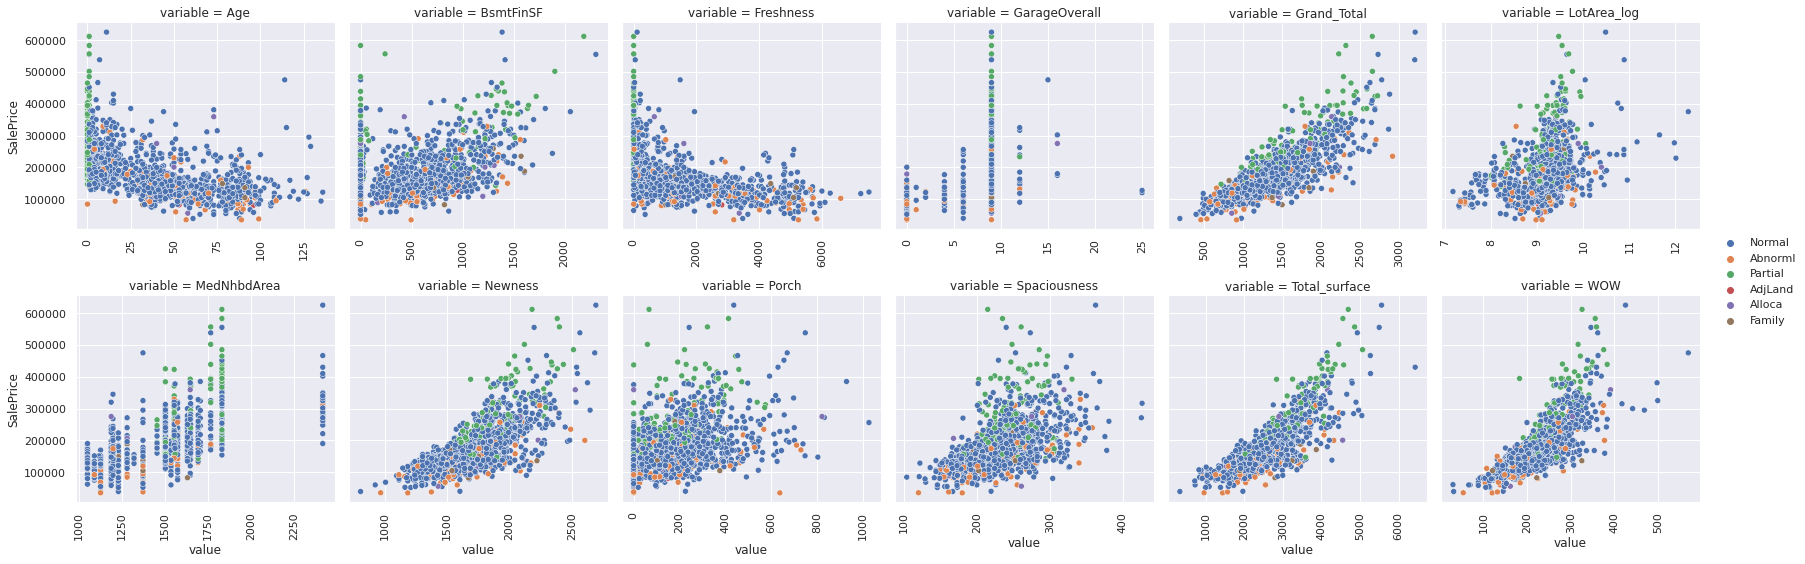

In [16]:
%%time
# 这里的hue是指用saleconditon来进行不同颜色的点区分
def plot(x,y,hue, **kwargs):
    sns.scatterplot(x=x,y=y, hue=hue)
    _=plt.xticks(rotation=90)

f = pd.melt(df[df.Set == "Train"], id_vars=['SalePrice','SaleCondition'], value_vars=check)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=True, height=4);
g = g.map(plot, "value", "SalePrice", 'SaleCondition')
g.add_legend()

CPU times: user 4.61 s, sys: 277 ms, total: 4.89 s
Wall time: 4.52 s


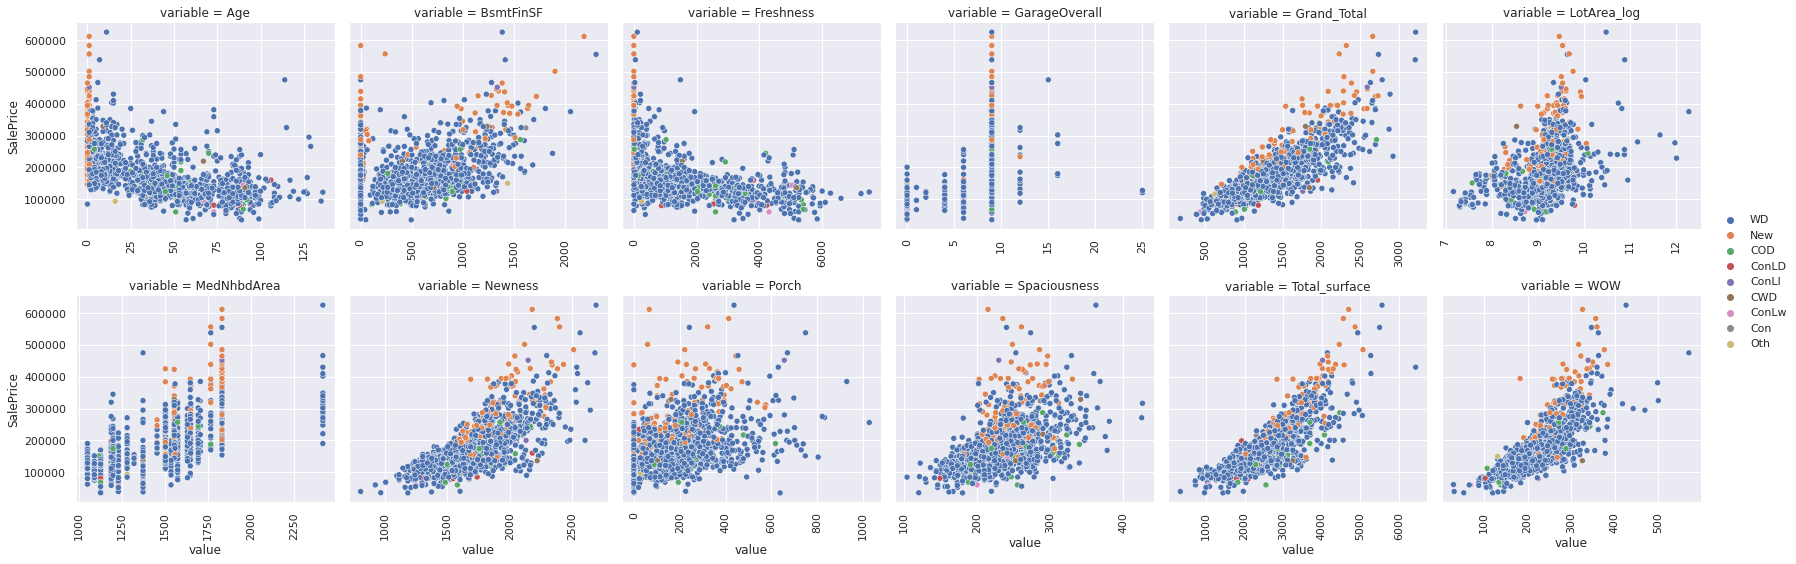

In [17]:
%%time
def plot(x,y,hue, **kwargs):
    sns.scatterplot(x=x,y=y, hue=hue);
    _=plt.xticks(rotation=90)

f = pd.melt(df[df.Set == "Train"], id_vars=['SalePrice','SaleType'], value_vars=check)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=True, height=4);
g = g.map(plot, "value", "SalePrice", 'SaleType')
g.add_legend()

## Mutual information

mutual information越高代表dependency越强，0代表二者独立

In [18]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [19]:
_X = df[df.Set == "Train"].copy()
_X.drop(['index','Id'], axis=1, inplace =True)
mi_scores = make_mi_scores(_X, _X.pop('SalePrice'))
mi_scores.head(20)

Total_surface    0.675530
Grand_Total      0.636476
WOW              0.633782
OverallQual      0.573361
Neighborhood     0.532815
Newness          0.507044
MedNhbdArea      0.489509
Overall          0.446820
MSZ_Age          0.434051
GrLivArea        0.434046
YearBuilt        0.410558
Freshness        0.401393
LotArea          0.395522
GarageWow        0.376954
GarageCars       0.368048
GarageArea       0.366640
Age              0.365451
TotalBsmtSF      0.364786
BsmtQual         0.329980
KitchenQual      0.329867
Name: MI Scores, dtype: float64

In [20]:
mi_scores.tail(20)

RoofStyle       1.612129e-02
Heating         1.610487e-02
BsmtFullBath    1.539912e-02
BsmtFinSF2      1.410345e-02
YrSold          1.243055e-02
RoofMatl        6.520277e-03
LowQualFinSF    6.423513e-03
BsmtHalfBath    6.271551e-03
LandSlope       3.826453e-03
Functional      2.915057e-03
MiscFeature     2.503619e-03
3SsnPorch       1.972453e-03
Condition2      1.289160e-03
Street          5.951774e-04
MiscVal         2.849766e-04
Utilities       1.110223e-15
PoolArea        1.110223e-16
MoSold          0.000000e+00
Set             0.000000e+00
PoolQC          0.000000e+00
Name: MI Scores, dtype: float64

## Construct new feature with 2 correlated features

这一部分建立新的特征(以X+数字命名)，主要的思想在于某一单个特征（如Condition或者Quality等），其对房价的影响会随着具体某一numeric feature的变化而有所变大（如在一定房屋面积下，房子的建造材质是水泥还是木头对房价的影响会很显著，但如果单个看房子的建造材质就会因为没区分面积而没有意义），即两个特征的联合关系可能会影响很大，因此这部分通过区分type的方式建立新特征，相当于间接把categorical feature以numeric的形式反映了出来。

GrLivArea: Above grade (ground) living area square feet<br>
BldgType: Type of dwelling<br>
确定GrlivArea和BldgType的联合关系，并建立新的特征

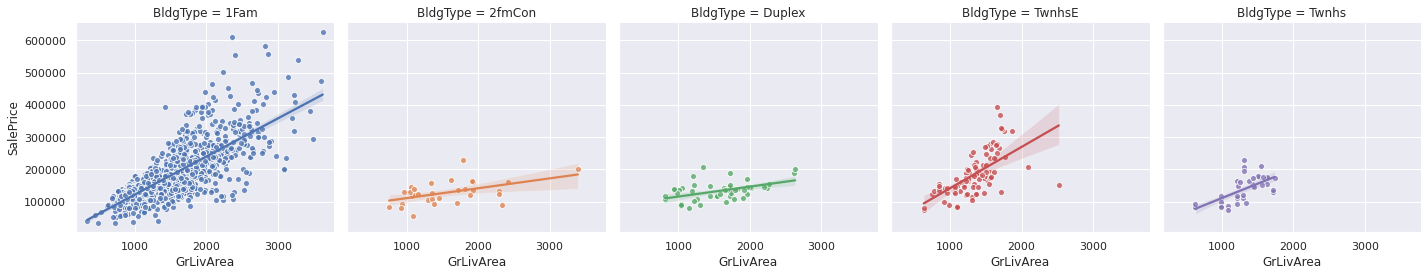

In [21]:
# 以bldgtype作为分类依据，绘制GrLivArea下的拟合回归直线
sns.lmplot(
    x='GrLivArea', y="SalePrice", hue="BldgType", col="BldgType",
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=4,
)

In [22]:
X1 = pd.get_dummies(df.BldgType, prefix = 'Bldg')
X1 = X1.mul(df.GrLivArea, axis=0)
X1[X1.columns] = mm.fit_transform(X1[X1.columns])
X1.head(10)

Bldg_1Fam  Bldg_2fmCon  Bldg_Duplex  Bldg_Twnhs  Bldg_TwnhsE
0   0.621084    -0.139483    -0.189199   -0.178311     -0.28348
1   0.008051    -0.139483    -0.189199   -0.178311     -0.28348
2   0.725081    -0.139483    -0.189199   -0.178311     -0.28348
3   0.630663    -0.139483    -0.189199   -0.178311     -0.28348
4   1.288853    -0.139483    -0.189199   -0.178311     -0.28348
5   0.144889    -0.139483    -0.189199   -0.178311     -0.28348
6   0.599190    -0.139483    -0.189199   -0.178311     -0.28348
7   1.141068    -0.139483    -0.189199   -0.178311     -0.28348
8   0.708661    -0.139483    -0.189199   -0.178311     -0.28348
9  -1.718843     4.511994    -0.189199   -0.178311     -0.28348

GrLivArea: Above grade (ground) living area square feet<br>
Neighborhood: Physical locations within Ames city limits<br>

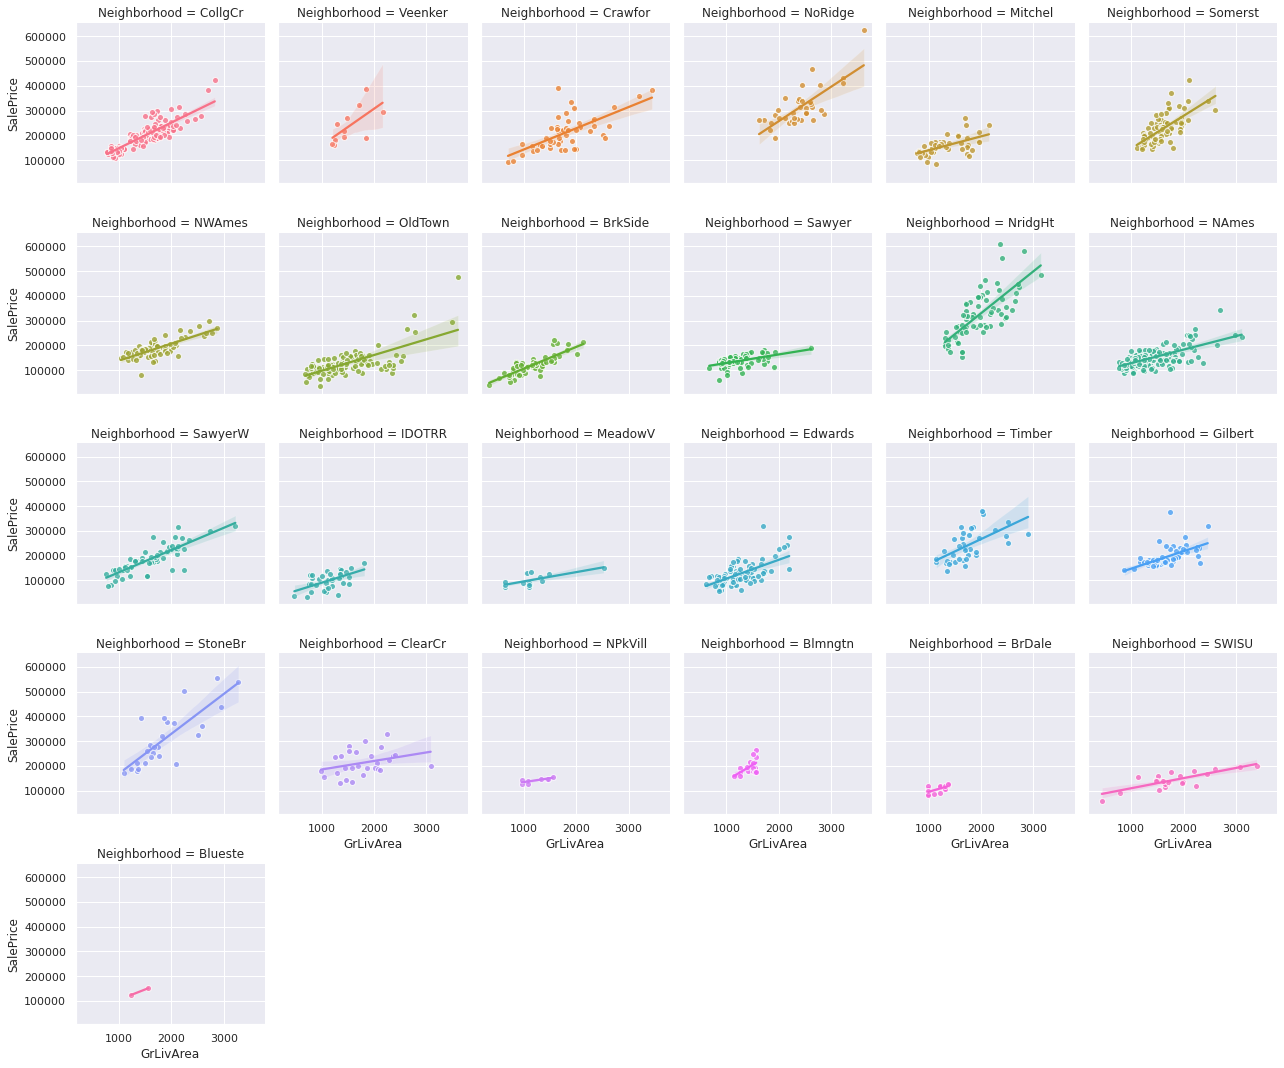

In [23]:
sns.lmplot(
    x='GrLivArea', y="SalePrice", hue="Neighborhood", col="Neighborhood",
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=6, height=3,
)

In [24]:
X2 = pd.get_dummies(df.Neighborhood, prefix = 'NB')
X2 = X2.mul(df.GrLivArea, axis=0)
X2[X2.columns] = mm.fit_transform(X2[X2.columns])
X2.head(10)

NB_Blmngtn  NB_Blueste  NB_BrDale  NB_BrkSide  NB_ClearCr  NB_CollgCr  \
0   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328    3.504004   
1   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328   -0.305271   
2   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328    3.673306   
3   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328   -0.305271   
4   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328   -0.305271   
5   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328   -0.305271   
6   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328   -0.305271   
7   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328   -0.305271   
8   -0.097921   -0.058124   -0.10115   -0.188001   -0.120328   -0.305271   
9   -0.097921   -0.058124   -0.10115    4.237445   -0.120328   -0.305271   

   NB_Crawfor  NB_Edwards  NB_Gilbert  NB_IDOTRR  ...  NB_NoRidge  NB_NridgHt  \
0   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
1   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
2   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
3    5.025444   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
4   -0.184720   -0.246798   -0.240837  -0.172101  ...    5.730601   -0.239206   
5   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
6   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
7   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
8   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   
9   -0.184720   -0.246798   -0.240837  -0.172101  ...   -0.153677   -0.239206   

   NB_OldTown  NB_SWISU  NB_Sawyer  NB_SawyerW  NB_Somerst  NB_StoneBr  \
0   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
1   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
2   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
3   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
4   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
5   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
6   -0.279330 -0.121952  -0.223401   -0.202662    4.021452   -0.127722   
7   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
8    3.941289 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   
9   -0.279330 -0.121952  -0.223401   -0.202662   -0.252819   -0.127722   

   NB_Timber  NB_Veenker  
0  -0.155783   -0.087751  
1  -0.155783    7.304531  
2  -0.155783   -0.087751  
3  -0.155783   -0.087751  
4  -0.155783   -0.087751  
5  -0.155783   -0.087751  
6  -0.155783   -0.087751  
7  -0.155783   -0.087751  
8  -0.155783   -0.087751  
9  -0.155783   -0.087751  

[10 rows x 25 columns]

TotalBsmtSF: Total square feet of basement area<br>
BsmtQual: Evaluates the height of the basement

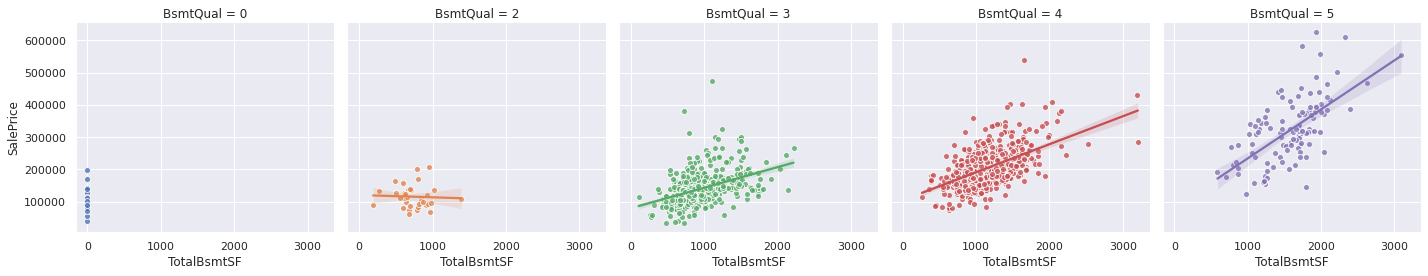

In [25]:
sns.lmplot(
    x='TotalBsmtSF', y="SalePrice", hue="BsmtQual", col="BsmtQual",
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=4,
)

In [26]:
X3 = pd.get_dummies(df.BsmtQual, prefix = 'BSQ')
X3 = X3.mul(df.TotalBsmtSF, axis=0)
X3[X3.columns] = mm.fit_transform(X3[X3.columns])
X3.head(10)

BSQ_0     BSQ_2     BSQ_3     BSQ_4     BSQ_5
0 -0.024762 -0.167702 -0.820045  0.650330 -0.296244
1 -0.024762 -0.167702 -0.820045  1.324975 -0.296244
2 -0.024762 -0.167702 -0.820045  0.756678 -0.296244
3 -0.024762 -0.167702  0.654547 -0.772074 -0.296244
4 -0.024762 -0.167702 -0.820045  1.130558 -0.296244
5 -0.024762 -0.167702 -0.820045  0.550629 -0.296244
6 -0.024762 -0.167702 -0.820045 -0.772074  3.244676
7 -0.024762 -0.167702 -0.820045  1.067414 -0.296244
8 -0.024762 -0.167702  1.036849 -0.772074 -0.296244
9 -0.024762 -0.167702  1.112919 -0.772074 -0.296244

GrLivArea: Above grade (ground) living area square feet<br>
MSZoning: Identifies the general zoning classification of the sale

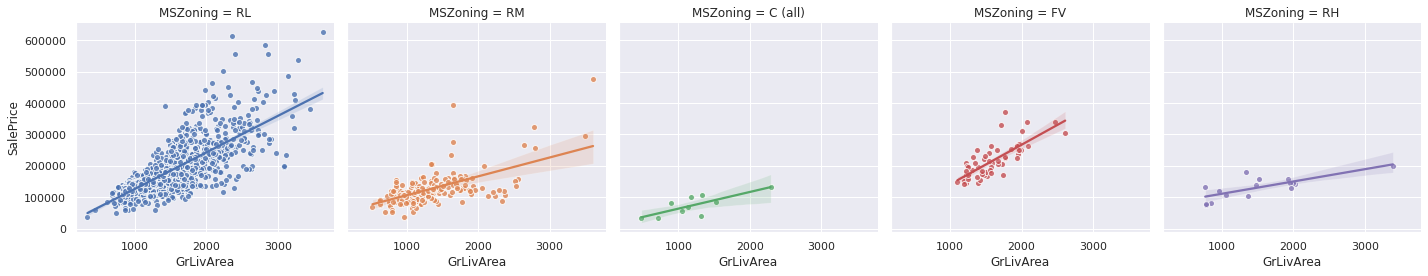

In [27]:
sns.lmplot(
    x='GrLivArea', y="SalePrice", hue='MSZoning', col='MSZoning',
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=5, height=4,
)

In [28]:
X4 = pd.get_dummies(df.MSZoning, prefix = 'MSZ')
X4 = X4.mul(df.GrLivArea, axis=0)
X4[X4.columns] = mm.fit_transform(X4[X4.columns])

GrLivArea: Above grade (ground) living area square feet<br>
SaleCondition: Condition of sale

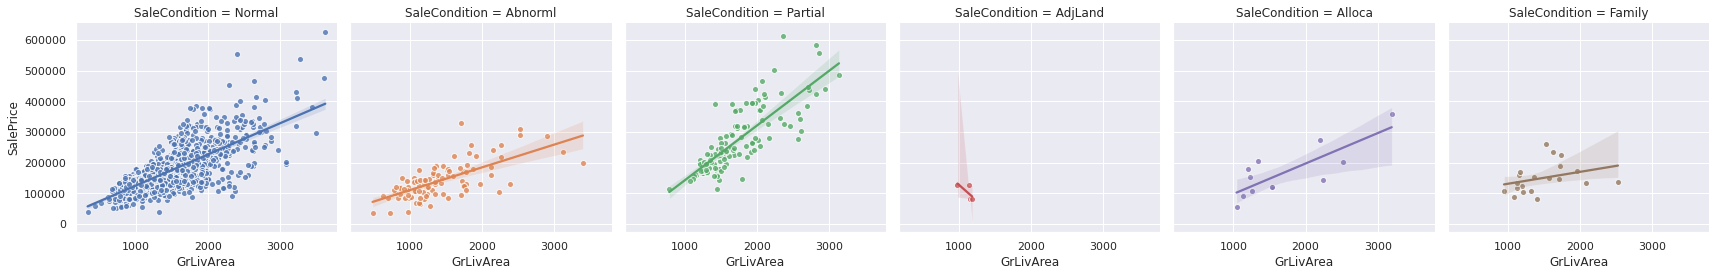

In [29]:
sns.lmplot(
    x='GrLivArea', y="SalePrice", hue='SaleCondition', col='SaleCondition',
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=6, height=4,
)

In [30]:
X5 = pd.get_dummies(df.SaleCondition, prefix = 'SaleCond')
X5 = X5.mul(df.GrLivArea, axis=0)
X5[X5.columns] = mm.fit_transform(X5[X5.columns])

Age: 自己建立的新特征 df['Age'] = df.YrSold - df.YearBuilt<br>
MSZoning: Identifies the general zoning classification of the sale.

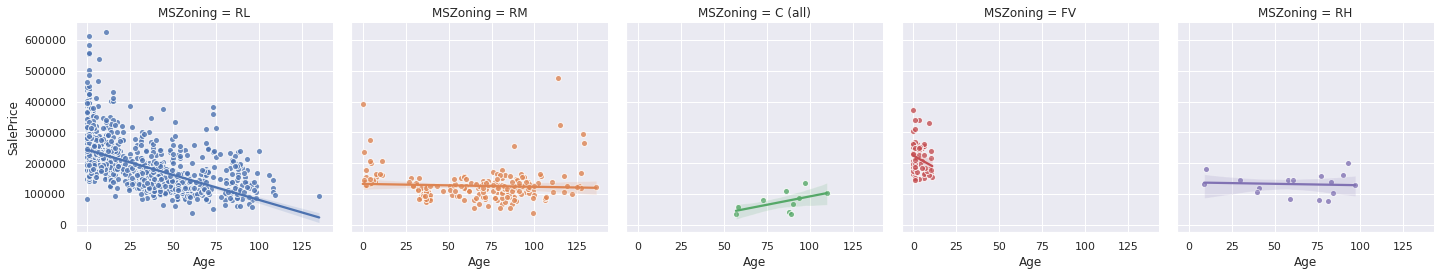

In [31]:
sns.lmplot(
    x='Age', y="SalePrice", hue='MSZoning', col='MSZoning',
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=6, height=4,
)

In [32]:
X6 = pd.get_dummies(df.MSZoning, prefix = 'MSZ')
X6 = X6.mul(df.Age, axis=0)
X6[X6.columns] = mm.fit_transform(X6[X6.columns])

WOW: 新建立的特征: df['WOW'] = np.sqrt(df['Overall'] * df['GrLivArea']) <br>
SaleCondition: Condition of sale

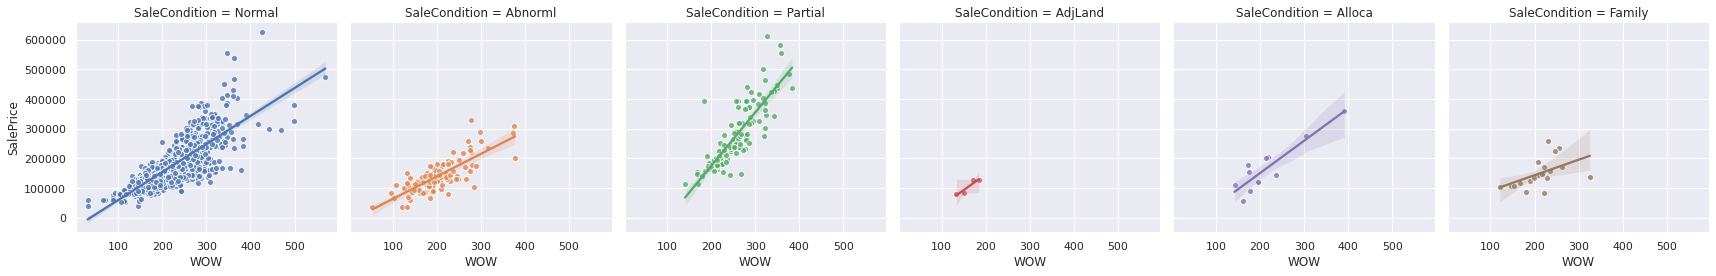

In [33]:
sns.lmplot(
    x='WOW', y="SalePrice", hue='SaleCondition', col='SaleCondition',
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=6, height=4,
)

In [34]:
X7 = pd.get_dummies(df.SaleCondition, prefix = 'SC2')
X7 = X7.mul(df.WOW, axis=0)
X7[X7.columns] = mm.fit_transform(X7[X7.columns])

Age: 自己建立的新特征 df['Age'] = df.YrSold - df.YearBuilt<br>
MSSubClass: Identifies the type of dwelling involved in the sale.

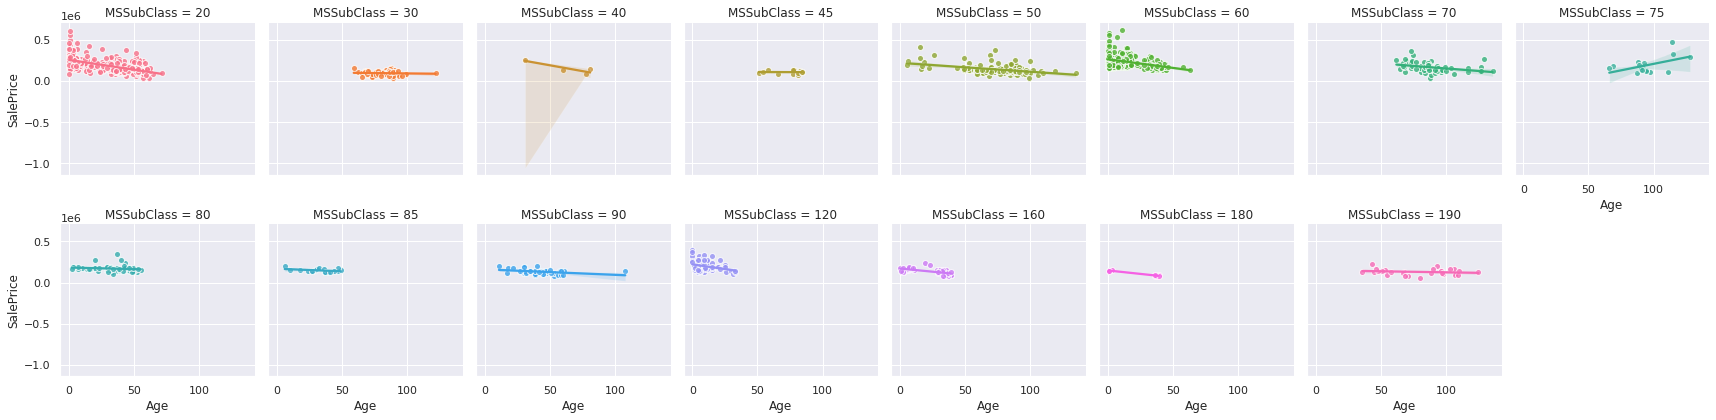

In [35]:
sns.lmplot(
    x='Age', y="SalePrice", hue='MSSubClass', col='MSSubClass',
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=8, height=3,
)

In [36]:
X8 = pd.get_dummies(df.MSSubClass, prefix = 'MSSC_AGE')
X8 = X8.mul(df.Age, axis=0)
X8[X8.columns] = mm.fit_transform(X8[X8.columns])

WOW: 新建立的特征: df['WOW'] = np.sqrt(df['Overall'] * df['GrLivArea']) <br>
SaleType: Type of sale

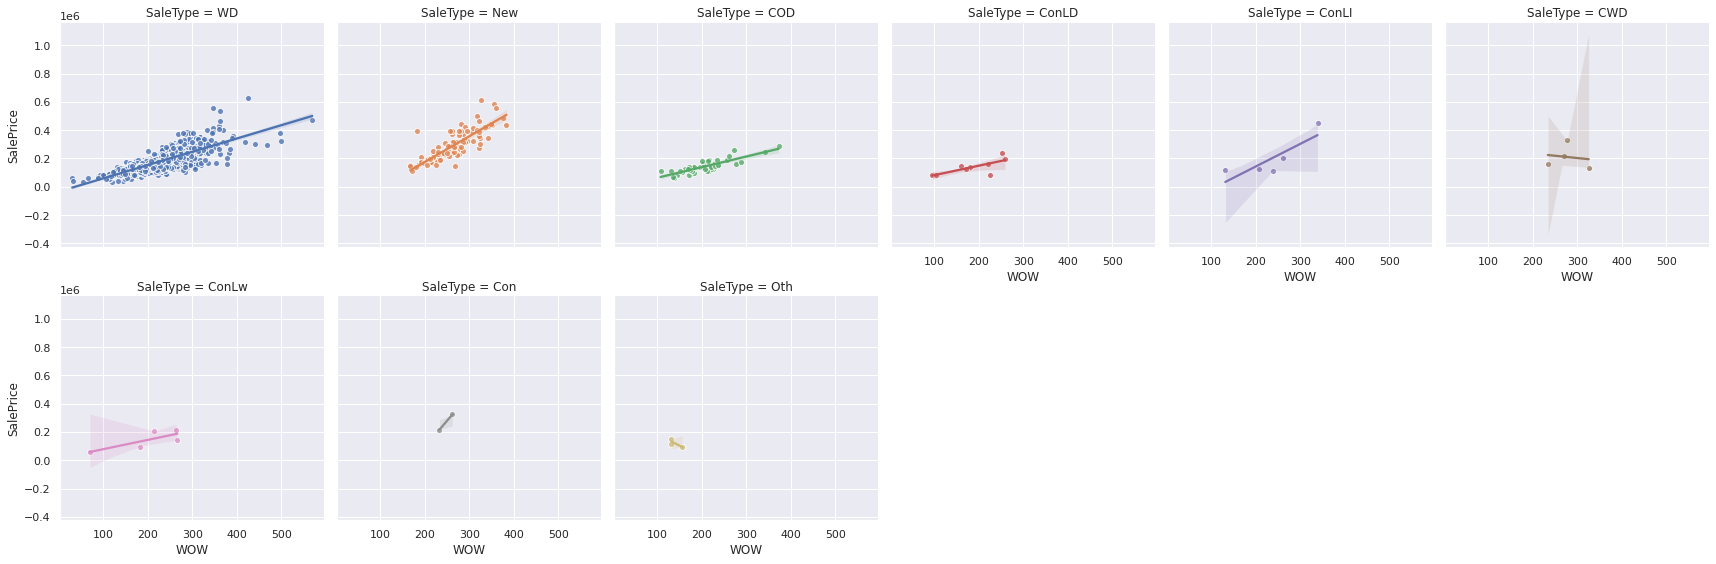

In [37]:
sns.lmplot(
    x='WOW', y="SalePrice", hue='SaleType', col='SaleType',
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=6, height=4,
)

In [38]:
X9 = pd.get_dummies(df.SaleType, prefix = 'ST')
X9 = X9.mul(df.WOW, axis=0)
X9[X9.columns] = mm.fit_transform(X9[X9.columns])

GarageWow: 建立的新特征：df['GarageWow'] = df.GarageOverall * df.GarageArea<br>
GarageFinish: Interior finish of the garage

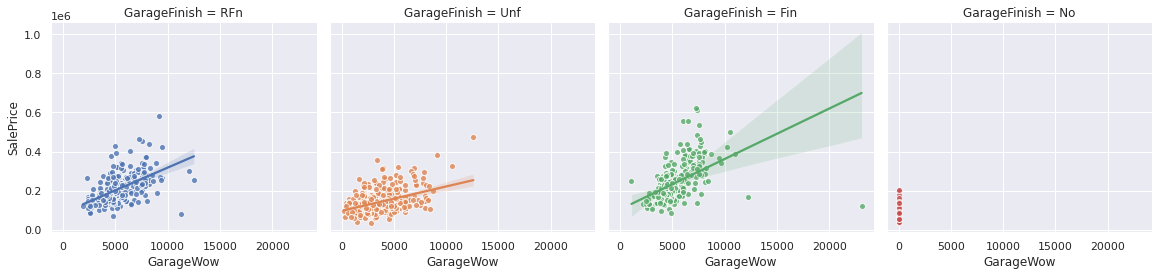

In [39]:
sns.lmplot(
    x='GarageWow', y="SalePrice", hue='GarageFinish', col='GarageFinish',
    data=df[df.Set == "Train"], scatter_kws={"edgecolor": 'w'}, col_wrap=6, height=4,
)

In [40]:
X10 = pd.get_dummies(df.GarageFinish, prefix = 'GF')
X10 = X10.mul(df.GarageWow, axis=0)
X10[X10.columns] = mm.fit_transform(X10[X10.columns])

## Target encoding

将categorical feature转为numeric。<br>
由于以下列出的特征都为类别较多（即可取值数目较多）的特征，直接使用one-hot编码会生成太多维度，因此这里采用target encoding。原理便是和另一特征（这里显然选择SalePrice更为合适）关联，通过计算A特征各类别在B特征上的均值来代表各类别被编码过后对应的数值。这里通过MEstimateEncoder实现。

In [41]:
df['SaleTypeCat'] = df.SaleType
df['SaleConditionCat'] = df.SaleCondition

In [42]:
encode_features = ['MSSubClass','SaleType','OverallCond','HouseStyle','GarageType', 'SaleCondition']
X_encode = df[df.Set == 'Train'].sample(frac=0.2, random_state=13)
y_encode = X_encode.pop("SalePrice")

In [43]:
encoder = MEstimateEncoder(cols=encode_features,m=1)
encoder.fit(X_encode, y_encode)
ENC = encoder.transform(df.drop("SalePrice", axis=1))
df[encode_features] = ENC[encode_features]
df[encode_features].head()

MSSubClass       SaleType    OverallCond     HouseStyle     GarageType  \
0  232920.344387  169748.526233  199268.942366  202547.218480  195281.014714   
1  177773.361339  169748.526233  145994.192802  171218.490717  195281.014714   
2  232920.344387  169748.526233  199268.942366  202547.218480  195281.014714   
3  151865.055269  169748.526233  199268.942366  202547.218480  140555.233290   
4  232920.344387  169748.526233  199268.942366  202547.218480  195281.014714   

   SaleCondition  
0  172904.176294  
1  172904.176294  
2  172904.176294  
3  141627.603952  
4  172904.176294

## Drop & Classify

新特征的一些来源特征可以被drop掉

In [44]:
drop_cols = ['LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
             'MiscVal','MoSold','YrSold','1stFlrSF','2ndFlrSF' ,'BsmtUnfSF', 'YearBuilt','YearRemodAdd', 'BldgType','Neighborhood','BsmtQual','MiscFeature','Street', 'PoolQC',
             'LandSlope','RoofMatl','LotConfig','RoofStyle','BsmtHalfBath','Functional','Heating','Grand_Total', "Fresh",'MSZ_Age','BsmtWow', 'Freshness','GarageFinish']

numeric = sorted(['LotFrontage','MasVnrArea','BsmtFinSF','GrLivArea','GarageArea','Porch','Total_surface', 'Age','RemodAge','OverallQual', 'GarageCars','LotArea',
           'ExterQual','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','Overall','Exterior_Overall', 'LotArea_log',
                  'TotRmsAbvGrd', "Spaciousness", 'BedroomAbvGr', 'Porch_types','WOW',"MedNhbdArea", 'TotalBsmtSF', 'Newness', 'SaleType','OverallCond','HouseStyle',
                  'GarageType', 'SaleCondition','MSSubClass','GarageOverall','GarageWow','BsmtCond','BsmtFinSF1','BsmtFinSF2'])

categorical = sorted(['Alley','LotShape','LandContour','MasVnrType','Foundation','BsmtExposure','Electrical', 'BsmtFullBath','HalfBath','FullBath',
                'Fireplaces','KitchenAbvGr','PavedDrive','Fence','GarageAgeCat','Utilities','ExterCond', 'CentralAir', 'MSZoning',
                     'SaleTypeCat','SaleConditionCat',"New"])

In [45]:
df.drop(drop_cols, inplace = True, axis=1)
df[categorical] = df[categorical].astype('category')
df[numeric] = df[numeric].astype('float')

In [46]:
df.select_dtypes(["category"]).nunique().sort_values(ascending=False).head(5)

SaleTypeCat         9
SaleConditionCat    6
Foundation          6
Fence               5
FullBath            5
dtype: int64

## Numeric

CPU times: user 14.3 s, sys: 299 ms, total: 14.6 s
Wall time: 14.2 s


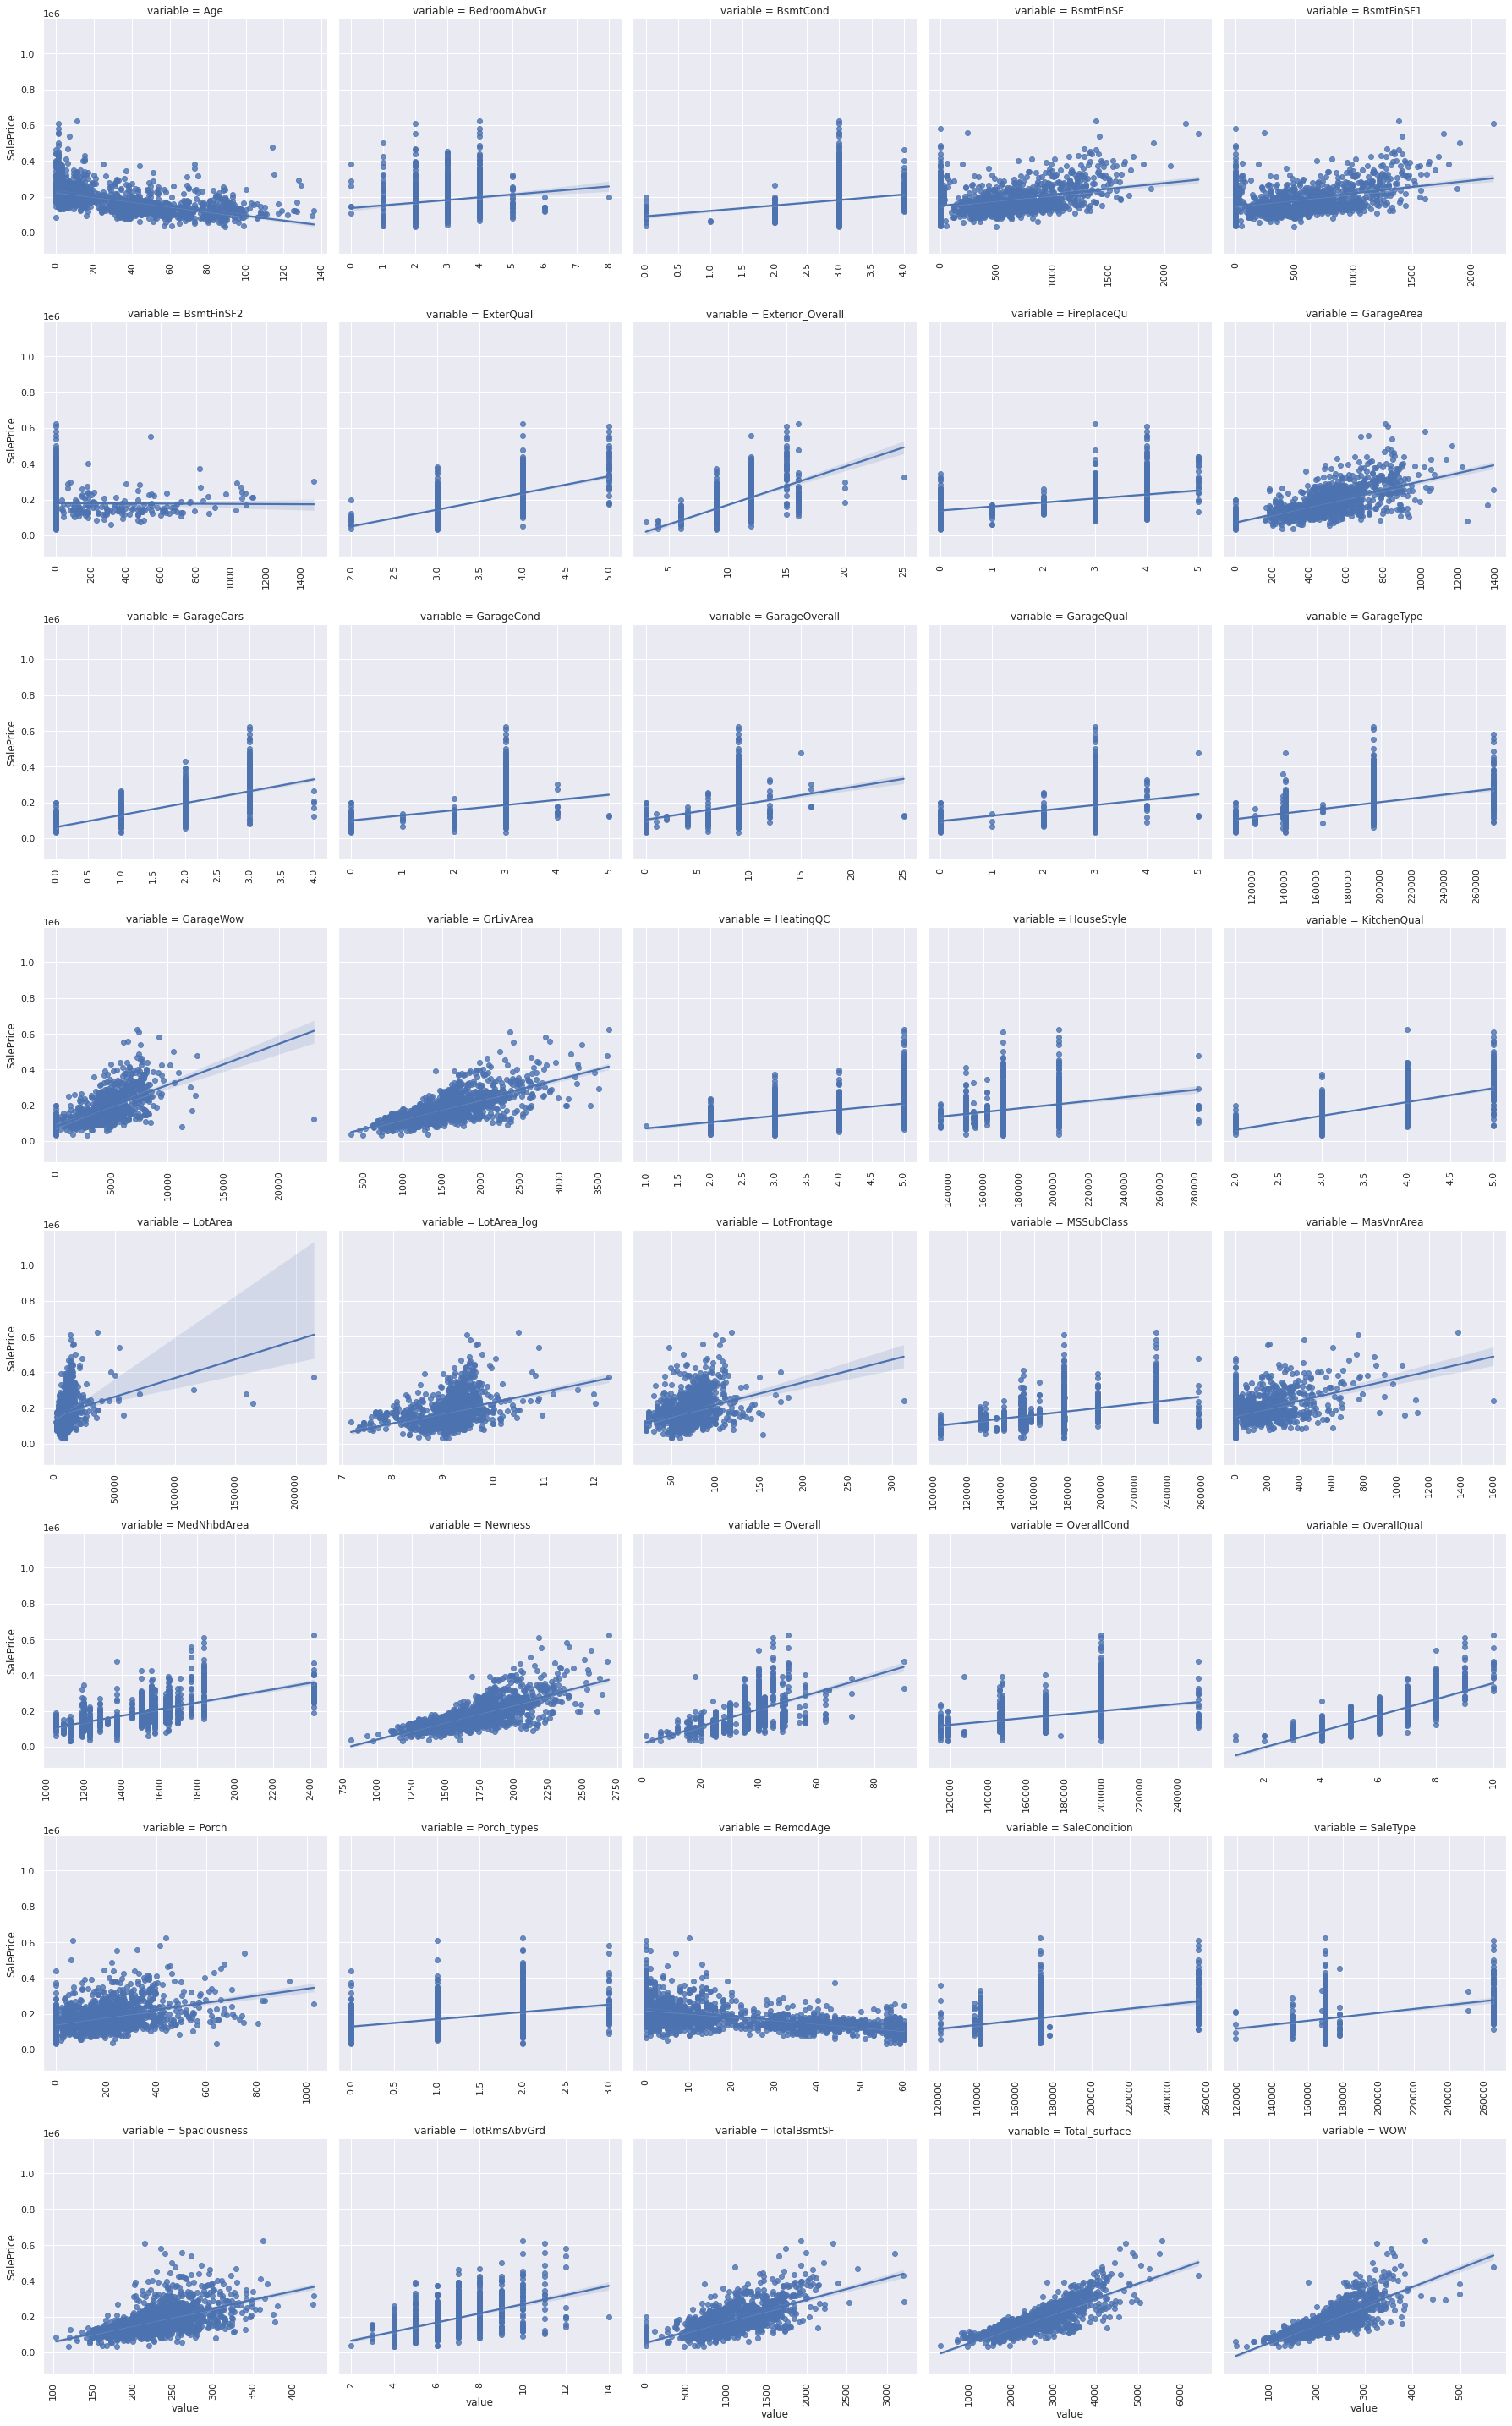

In [47]:
%%time
def scatterplot(x,y,**kwargs):
    sns.regplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df[df.Set == "Train"], id_vars=['SalePrice'], value_vars=numeric)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=True, height=5)
g = g.map(scatterplot, "value", "SalePrice")

In [48]:
df[numeric] = mm.fit_transform(df[numeric])

## Categorical

CPU times: user 3.75 s, sys: 251 ms, total: 4 s
Wall time: 3.62 s


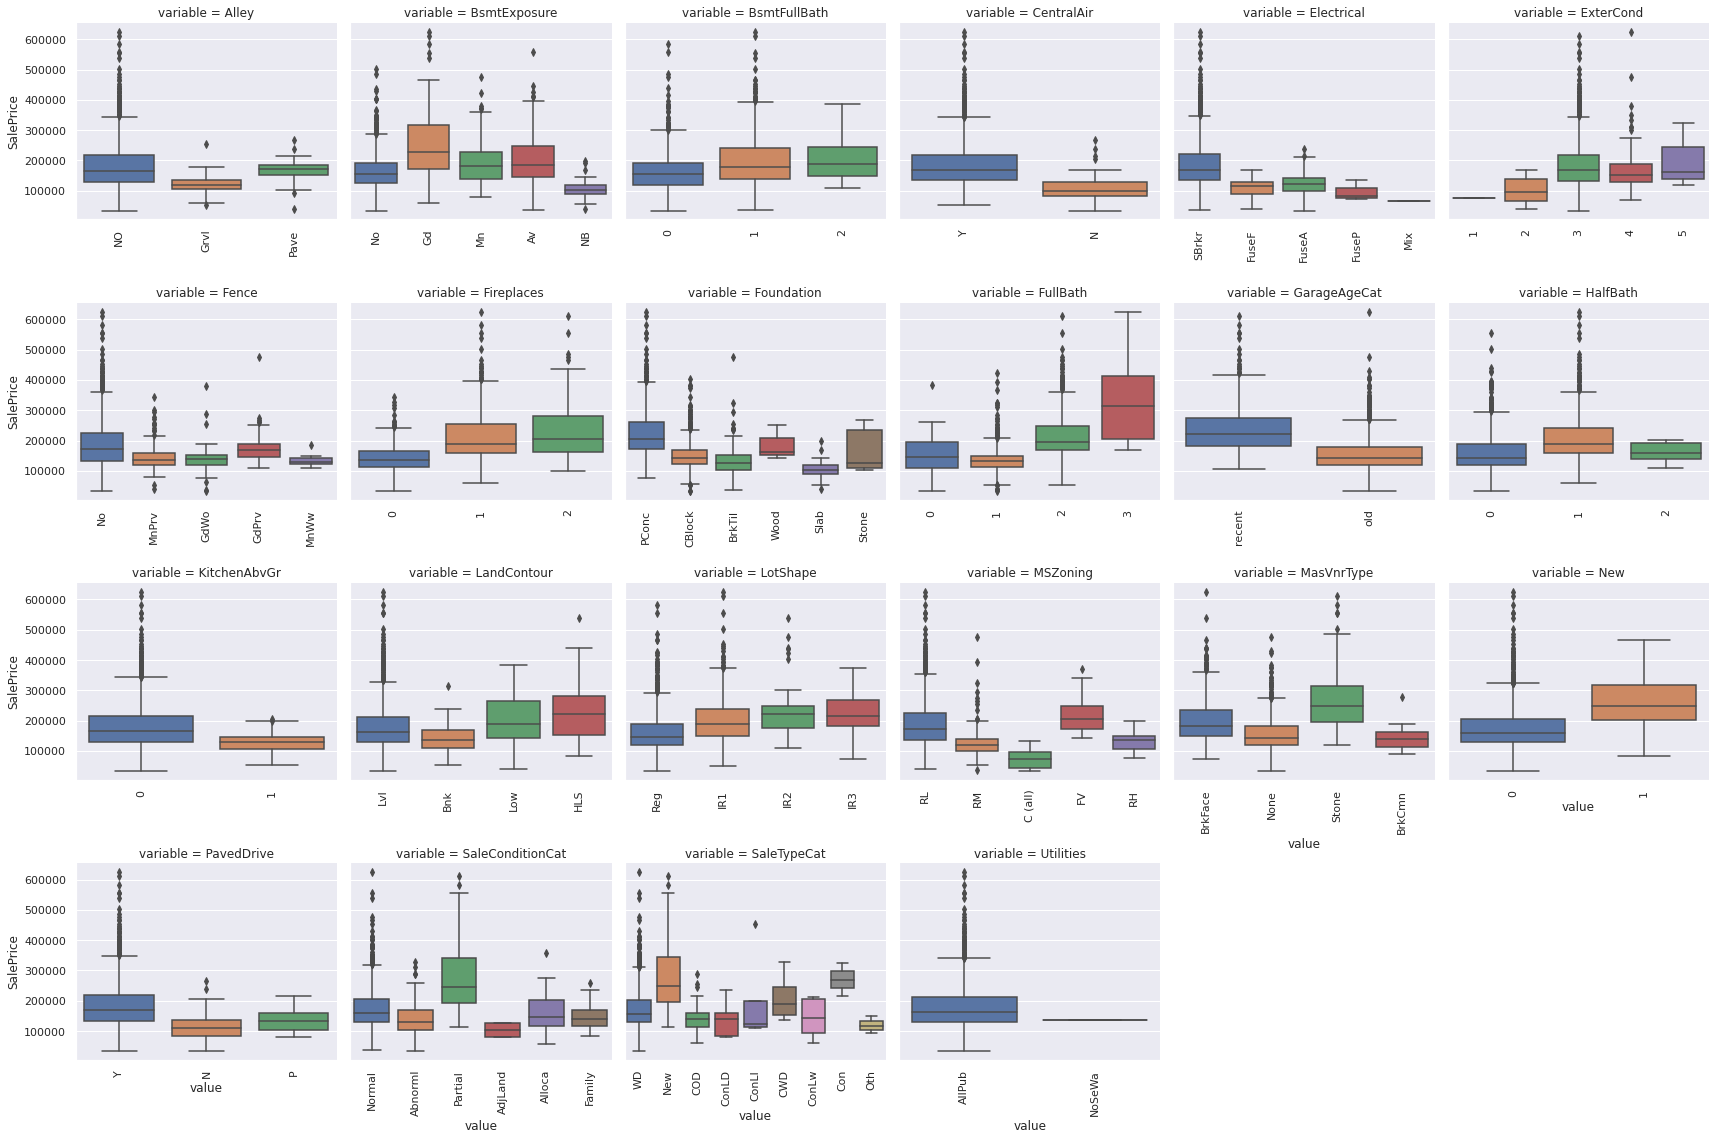

In [49]:
%%time
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df[df.Set == "Train"], id_vars=['SalePrice'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=True, height=4)
g = g.map(boxplot, "value", "SalePrice")

## Correlations

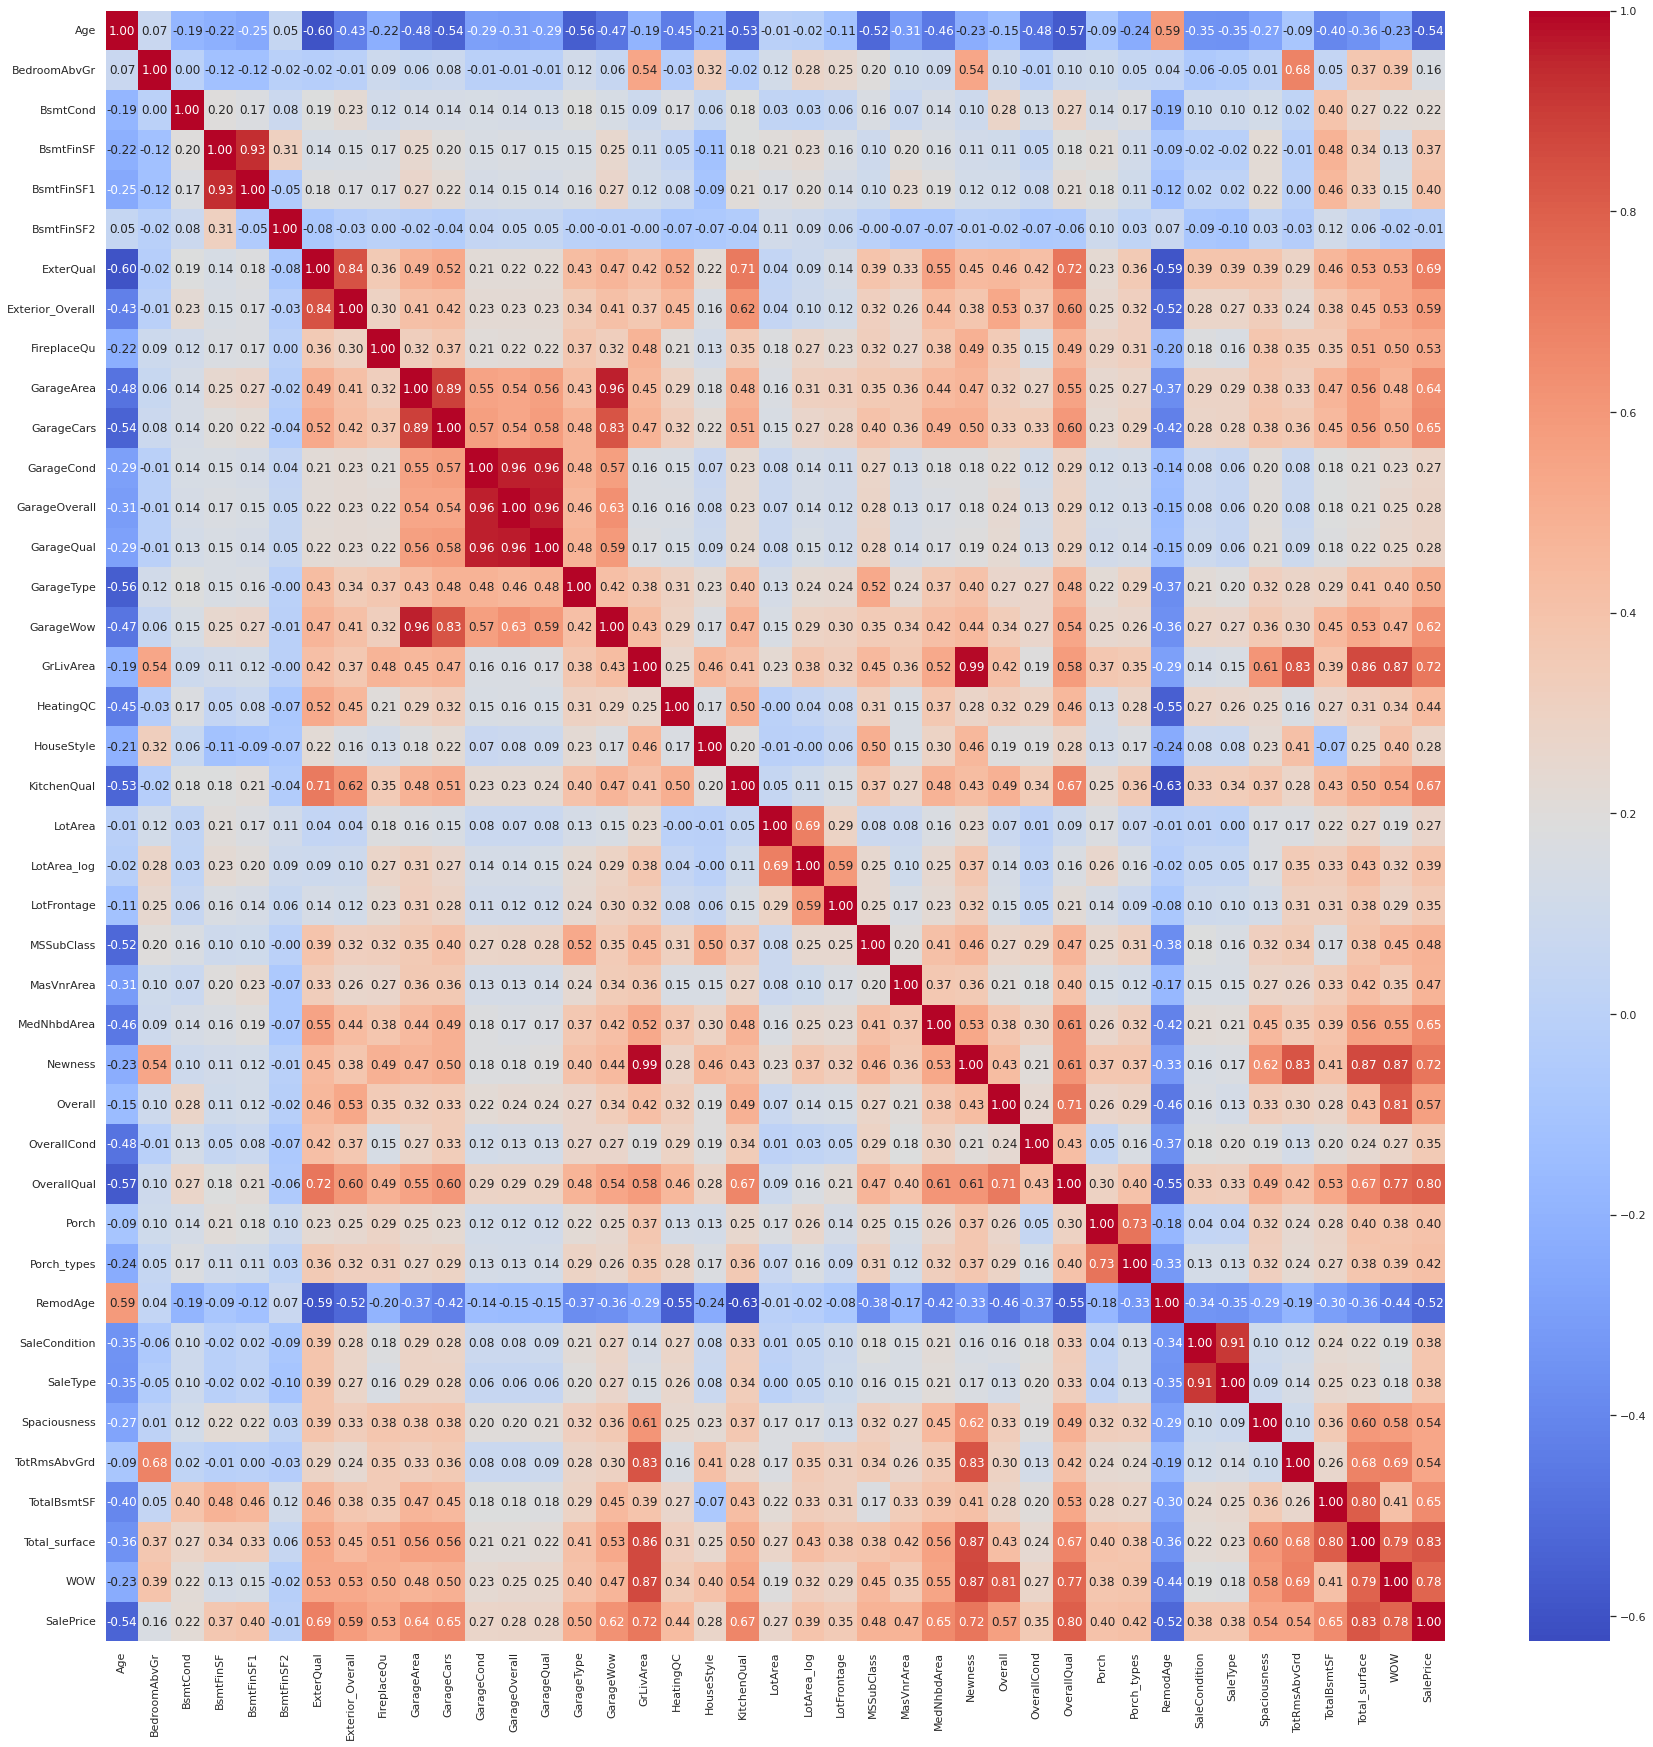

In [50]:
fig, ax = plt.subplots(figsize=(30,30))     
g = sns.heatmap(df[df.Set == 'Train'][[*numeric,'SalePrice']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

## Joining 'double categories' and converting to dummies

不同样本在某一categorical feature上取值的数目会有所不同，原来的数据会把这个feature拆开成两个特征，但是这样做会导致某一单独的特征并没有意义。如下：

- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)

这两个特征表达的含义其实是完全相同的，只不过一些样本用到了两种Exterior，有些样本只用了一种。个人认为这种分开特征的做法有一个明显的问题：对于同时包含两种exterior的样本，其单个特征（如Exterior1st）完全不会反应另一种特征，回归器在处理时相当于忽视了整体的特征，造成误判。

处理：对于所有取值，单独设一个特征，遍历原df并计数，最后舍弃原特征。新特征的取值为0或者1，标记有或者无

### Condition1,2

In [51]:
cond = df[['Condition1','Condition2']]
condition_cats = ["Condition_"+s for s in set([*cond.Condition1.unique(), *cond.Condition2.unique()])]
COND_FRAME = pd.DataFrame(columns=condition_cats, index = df.index).fillna(0)
for i in cond.index:
    cs = set(cond.loc[i, ['Condition1','Condition2']].values)
    for c in cs:
        COND_FRAME.loc[i]["Condition_"+c] = 1

     
df = df.join(COND_FRAME)
df.drop(['Condition1','Condition2'], axis=1, inplace = True)

CPU times: user 1.4 s, sys: 229 ms, total: 1.63 s
Wall time: 1.25 s


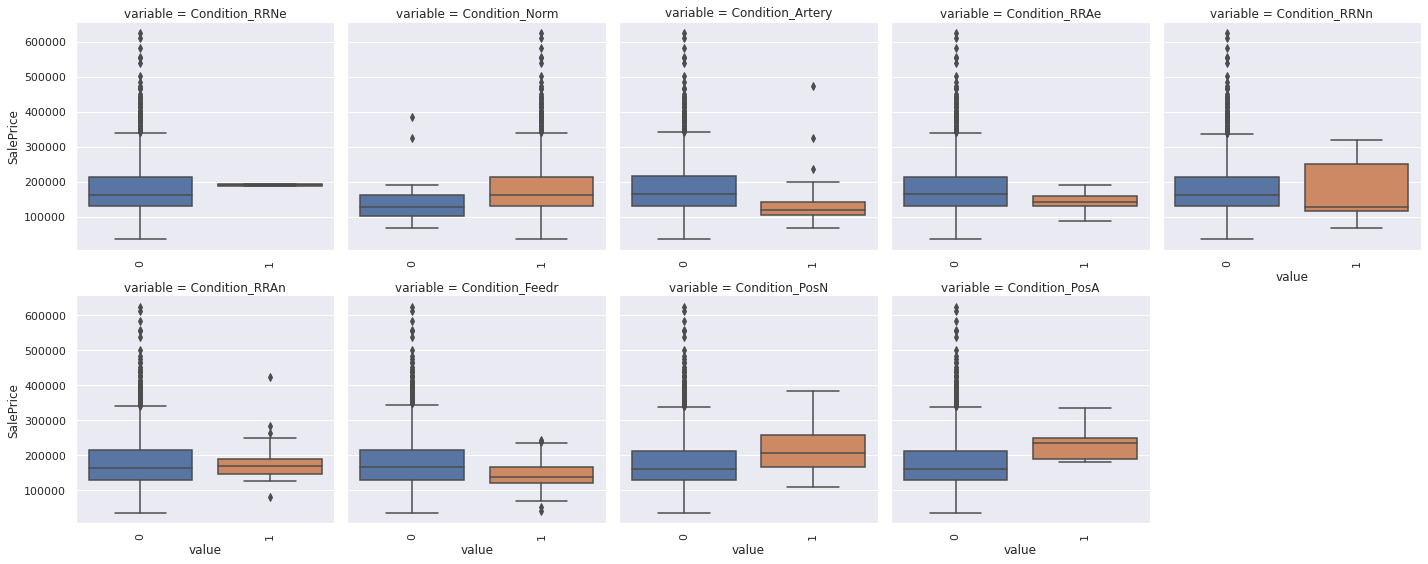

In [52]:
%%time
def scatterplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df[df.Set == "Train"], id_vars=['SalePrice'], value_vars=df[df.Set == 'Train'][df.filter(like='Condition_').columns])
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=True, height=4)
g = g.map(scatterplot, "value", "SalePrice")

### Exterior1st, Exterior2nd

由于exterior的含义是房子的外部材料，准确衡量实际上是其对应的单位价值*面积，因此这里乘了GrLivArea, 变为numeric feature

In [53]:
ext = df[['Exterior1st','Exterior2nd']]
ext_cats = ["Ext_"+s for s in set([*ext.Exterior1st.unique(), *ext.Exterior2nd.unique()])]
EXT_FRAME = pd.DataFrame(columns=ext_cats, index = df.index).fillna(0)
for i in ext.index:
    cs = set(ext.loc[i, ['Exterior1st','Exterior2nd']].values)
    for c in cs:
        EXT_FRAME.loc[i]["Ext_"+c] = 1

EXT_FRAME = EXT_FRAME.mul(df.GrLivArea, axis=0)  
df = df.join(EXT_FRAME)
df.drop(['Exterior1st','Exterior2nd'], axis=1, inplace = True)

CPU times: user 6.58 s, sys: 244 ms, total: 6.83 s
Wall time: 6.46 s


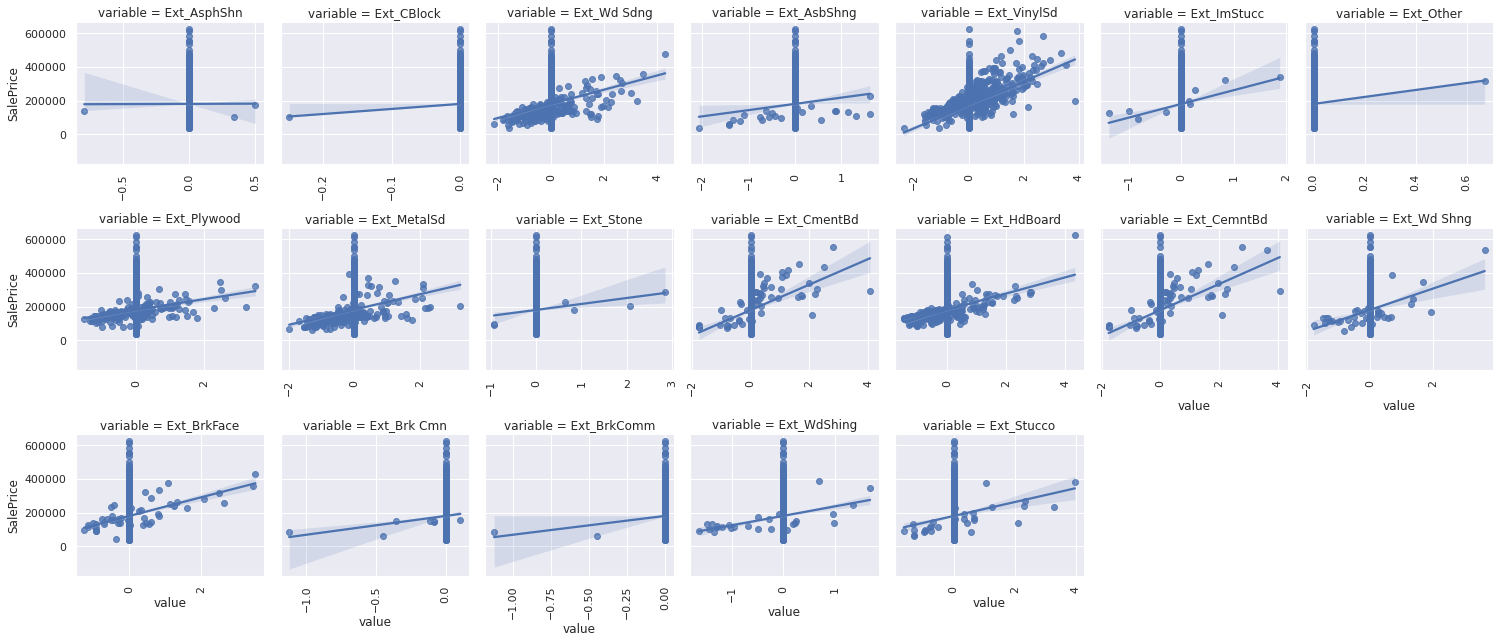

In [54]:
%%time
def scatterplot(x,y,**kwargs):
    sns.regplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df[df.Set == "Train"], id_vars=['SalePrice'], value_vars=df[df.Set == 'Train'][df.filter(like='Ext_').columns])
g = sns.FacetGrid(f, col="variable",  col_wrap=7, sharex=False, sharey=True, height=3)
g = g.map(scatterplot, "value", "SalePrice")

### BsmtFinType1,BsmtFinType2

这一部分同样涉及到乘面积来表示basement更为精确的问题。操作类似上一步exterior，只不过在遍历时就进行了填充

In [55]:
mulCols = ['BsmtFinSF1','BsmtFinSF2']
bf = df[['BsmtFinType1','BsmtFinType2']]
bf_cats = ["BF_"+s for s in set([*bf.BsmtFinType1.unique(), *bf.BsmtFinType2.unique()])]
BF_FRAME = pd.DataFrame(columns=bf_cats, index = df.index).fillna(0).astype("float")

for i in bf.index:
    cs = set(bf.loc[i, ['BsmtFinType1','BsmtFinType2']].values)
    for j,c in enumerate(cs):
        BF_FRAME.loc[i]["BF_"+c] =  df.loc[i][mulCols[j]]

df = df.join(BF_FRAME)
df.drop(['BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2'], axis=1, inplace = True)

CPU times: user 2.43 s, sys: 195 ms, total: 2.63 s
Wall time: 2.25 s


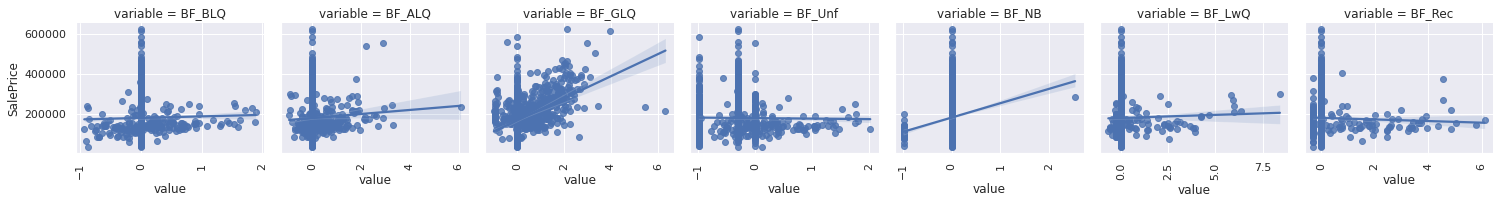

In [56]:
%%time
def scatterplot(x,y,**kwargs):
    sns.regplot(x=x,y=y)
    _=plt.xticks(rotation=90)

f = pd.melt(df[df.Set == "Train"], id_vars=['SalePrice'], value_vars=df[df.Set == 'Train'][df.filter(like="BF_").columns])
g = sns.FacetGrid(f, col="variable",  col_wrap=7, sharex=False, sharey=True, height=3)
g = g.map(scatterplot, "value", "SalePrice")

## Categorical to dummies

指定categorical对应的categorical feature进行类似于one hot编码的dummy编码。<br>
与上面使用target encoding不同，这里的categorical feature因为类别取值数较少，可以直接使用dummy编码而不会造成特征空间过大。

In [57]:
df = pd.get_dummies(df,columns=categorical, drop_first=True)

## Clustering

利用KMeans进行聚类，创建新的特征

In [58]:
clustering_features = ['GrLivArea','Total_surface', 'LotArea_log', 'Overall','WOW',"Spaciousness",'Porch','BsmtFinSF','Age', 'RemodAge']
kmeans = KMeans(n_clusters = 13, random_state=13)
clust_data = df[df.Set == 'Train'].loc[:, clustering_features]
clust_data['cluster'] = kmeans.fit_predict(clust_data)
clust_data['cluster'] = clust_data['cluster'].astype('category')
clust_data['SalePrice'] = df[df.Set == 'Train']['SalePrice']

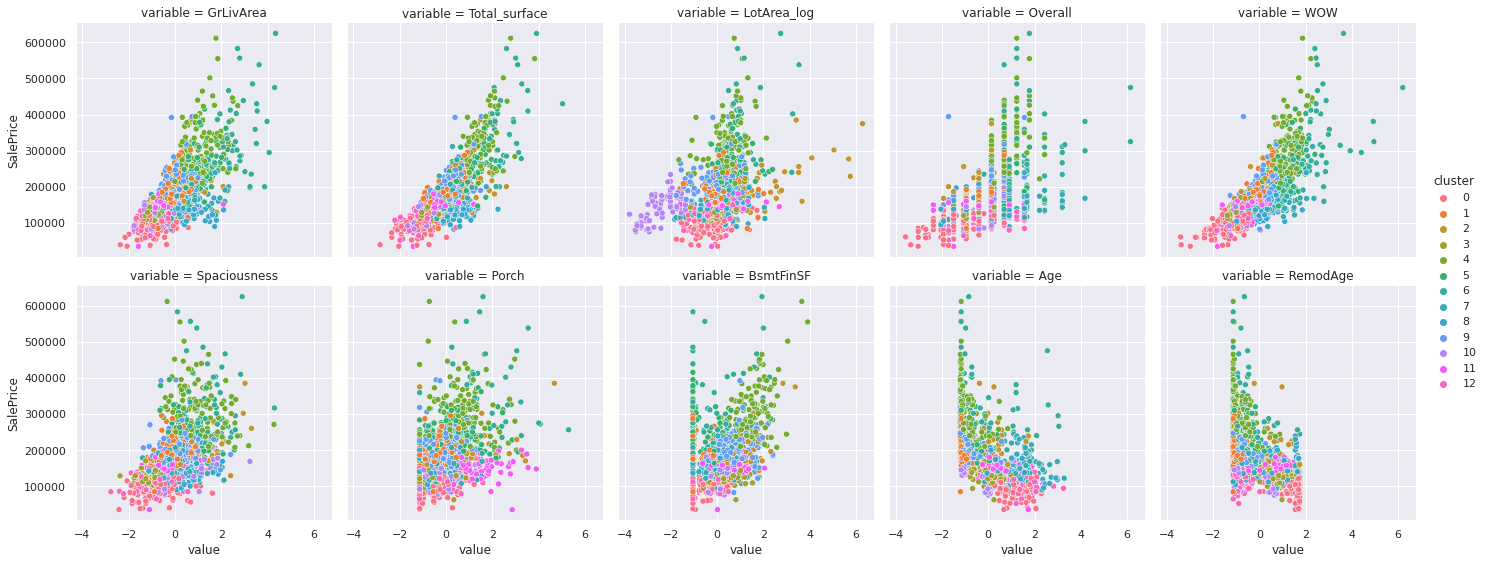

In [59]:
sns.relplot(data = clust_data.melt(value_vars=clustering_features, id_vars = ["SalePrice", "cluster"]), x="value", y="SalePrice", hue='cluster', col= "variable", col_wrap=5, height=4)

In [60]:
clust_data = df.loc[:, clustering_features]
X_CD = kmeans.fit_transform(clust_data)
X_CD = mm.fit_transform(X_CD)
X_CD = pd.DataFrame(X_CD, columns=[f"Centroid_{i}" for i in range(X_CD.shape[1])])

## Join interaction features

根据尝试，选择添加以下feature engineering中建立的新特征效果跟好：

In [61]:
df = df.join([X1, X2, X3, X_CD, X8, X10])
df.head()

index  Id  MSSubClass  LotFrontage   LotArea  HouseStyle  OverallQual  \
0      0   1    1.566366    -0.206809 -0.215718    1.305431     0.653002   
1      1   2    0.002574     0.502787 -0.068374   -0.288361    -0.059653   
2      2   3    1.566366    -0.064890  0.143033    1.305431     0.653002   
3      3   4   -0.732103    -0.443342 -0.074780    1.305431     0.653002   
4      4   5    1.566366     0.692013  0.528690    1.305431     1.365657   

   OverallCond  MasVnrArea  ExterQual  ...  MSSC_AGE_90  MSSC_AGE_120  \
0     0.719328    0.539144   1.046606  ...    -0.179742     -0.172282   
1    -1.203736   -0.568523  -0.682905  ...    -0.179742     -0.172282   
2     0.719328    0.346998   1.046606  ...    -0.179742     -0.172282   
3     0.719328   -0.568523  -0.682905  ...    -0.179742     -0.172282   
4     0.719328    1.409454   1.046606  ...    -0.179742     -0.172282   

   MSSC_AGE_150  MSSC_AGE_160  MSSC_AGE_180  MSSC_AGE_190    GF_Fin  GF_No  \
0     -0.018525     -0.178732     -0.063269     -0.138345 -0.528591    0.0   
1     -0.018525     -0.178732     -0.063269     -0.138345 -0.528591    0.0   
2     -0.018525     -0.178732     -0.063269     -0.138345 -0.528591    0.0   
3     -0.018525     -0.178732     -0.063269     -0.138345 -0.528591    0.0   
4     -0.018525     -0.178732     -0.063269     -0.138345 -0.528591    0.0   

     GF_RFn    GF_Unf  
0  1.469300 -0.735744  
1  1.140627 -0.735744  
2  1.693394 -0.735744  
3 -0.577433  2.029222  
4  2.544955 -0.735744  

[5 rows x 213 columns]

## Split

将训练集和测试集分开，并drop掉无关信息

In [62]:
train = df[df.Set == 'Train']
test = df[df.Set == 'test']
HouseIds = test.Id.to_list()
test = test.drop(['Id','Set',"SalePrice",'index'], axis = 1)
y = train.SalePrice
X = train.drop(['SalePrice','Id','Set','index'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 13)

In [63]:
print("Currently using {} feature columns".format(len(train.columns)))

Currently using 213 feature columns


# Models


以下尝试了若干回归模型，全部被注释掉的cell是通过GridSearchCV找寻最优regressor的训练过程，第一行有对应注释标明运行这个cell大致需要多长时间，第二块cell是经过尝试选择的最优候选regressor（被注释掉的是选取了两种比较典型但并非最优的version），注释仅为提示用，若只想看结果那么运行时无需取消注释。

## Random Forest

In [64]:
# %%time #1min
# param_grid = {'n_estimators': [500],'max_depth': [10, None], 'max_features':['auto','sqrt',0.9,0.75]}
# rf_grid = GridSearchCV(RandomForestRegressor(random_state=13, n_jobs=-1), param_grid, cv=4)
# rf_grid.fit(X, y)
# print(rf_grid.best_estimator_)
# print(rf_grid.best_params_)
# rf_score = rf_grid.best_score_
# print(rf_score) 

In [65]:
%%time
RF_model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13).fit(X_train,y_train)
# RF_model = RandomForestRegressor(max_features='sqrt', n_estimators=500, n_jobs=-1,random_state=13).fit(X_train,y_train) #v1
# RF_model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13,max_features="sqrt").fit(X_train,y_train) # v2

CPU times: user 23.5 s, sys: 169 ms, total: 23.6 s
Wall time: 6.43 s


<AxesSubplot:>

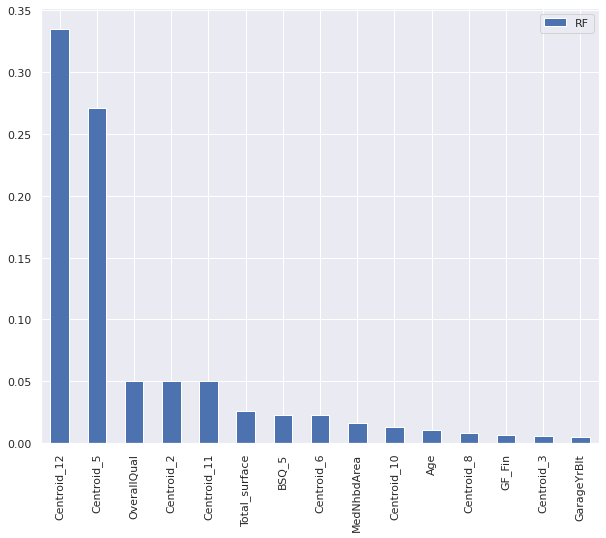

In [66]:
features = {}
for feature, importance in zip(X_train.columns, RF_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"RF":features})
importances.sort_values("RF", ascending = False, inplace=True)
importances[:15].plot.bar()

## Ridge

In [67]:
# %%time
# param_grid = {'alpha': [0.01,0.1, 1, 10, 100, 1000]}
# ridge_grid = GridSearchCV(Ridge(random_state=13), param_grid, cv=4)
# ridge_grid.fit(X, y)
# print(ridge_grid.best_estimator_)
# print(ridge_grid.best_params_)
# ridge_score = ridge_grid.best_score_
# print(ridge_score) 

In [68]:
%%time
ridge_model = Ridge(alpha=10, random_state=13).fit(X_train,y_train)
#ridge_model = Ridge(alpha=100, random_state=13).fit(X_train,y_train) #v1
# ridge_model = Ridge(alpha=100, random_state=13).fit(X_train,y_train) #v2

CPU times: user 26.5 ms, sys: 43 ms, total: 69.6 ms
Wall time: 24.9 ms


## Lasso

In [69]:
# %%time #2min
# param_grid = {'alpha': [1, 10, 100, 1000]}
# lasso_grid = GridSearchCV(Lasso(random_state=13, max_iter = 100000, fit_intercept = False), param_grid, cv=4)
# lasso_grid.fit(X, y)
# print(lasso_grid.best_estimator_)
# print(lasso_grid.best_params_)
# lasso_score = lasso_grid.best_score_
# print(lasso_score) 

In [70]:
%%time
lasso_model = Lasso(alpha=100, max_iter=10000, random_state=13).fit(X_train,y_train)
# lasso_model = Lasso(alpha=200, max_iter=100000, random_state=13).fit(X_train,y_train) #v1
# lasso_model = Lasso(alpha=100, max_iter=100000, random_state=13).fit(X_train,y_train) #v2

CPU times: user 4.79 s, sys: 3.86 s, total: 8.66 s
Wall time: 2.2 s


## ElasticNet

In [71]:
# %%time
# param_grid = {'alpha': [0.05, 0.5, 1],'l1_ratio':[0.1, 0.5, 0.9], 'tol':[1e-2]}
# elastic_grid = GridSearchCV(ElasticNet(random_state=13, max_iter = 1000), param_grid, cv=4)
# elastic_grid.fit(X, y)
# print(elastic_grid.best_estimator_)
# print(elastic_grid.best_params_)
# elastic_score = elastic_grid.best_score_
# print(elastic_score) 

In [72]:
%%time
elastic_model= ElasticNet(alpha=0.05, l1_ratio=0.75, max_iter=10000, random_state=13).fit(X_train,y_train)
# elastic_model= ElasticNet(alpha=0.5, l1_ratio=0.9, max_iter=10000, random_state=13, tol=0.01).fit(X_train,y_train) # v1
# elastic_model= ElasticNet(alpha=0.05, l1_ratio=0.1, max_iter=10000, random_state=13, tol=0.01).fit(X_train,y_train) # v2

CPU times: user 6.42 s, sys: 5.15 s, total: 11.6 s
Wall time: 3.06 s


## XGBoost

In [73]:
# %%time # 26min
# gbm_param_grid = {'learning_rate': [0.1],'n_estimators': [500, 1000],'subsample': [0.9],'reg_alpha':[0.001, 0.01], 'reg_lambda':[0.1,1,10]}
# # gbm_param_grid = {'learning_rate': [0.1],'n_estimators': [750, 1000],'subsample': [0.8, 0.9],'reg_alpha':[0.001, 0.01], 'reg_lambda':[0.1,1,10], 'max_depth': [4,6,8]}
# grid_xgb = GridSearchCV(xgb.XGBRegressor(seed = 13), gbm_param_grid,cv=4, scoring='neg_mean_squared_error', verbose = 1)
# grid_xgb.fit(X, y)
# print(grid_xgb.best_estimator_)
# print(grid_xgb.best_params_)
# xgb_score = grid_xgb.best_score_
# print(xgb_score) 

In [74]:
%%time
xg_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 500, seed = 13, subsample = 0.8, learning_rate = 0.1, reg_alpha=0.01, reg_lambda = 10).fit(X_train,y_train)
#xg_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 750, seed = 13, subsample = 0.9, max_depth=4, \
#                             learning_rate = 0.1, reg_alpha=0.01, reg_lambda = 0.1).fit(X_train,y_train)  #v1
# xg_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 500, seed = 13, subsample = 0.9, \
#                             learning_rate = 0.1, reg_alpha=0.01, reg_lambda = 1).fit(X_train,y_train)  #v2

CPU times: user 20.5 s, sys: 244 ms, total: 20.7 s
Wall time: 5.21 s


<AxesSubplot:>

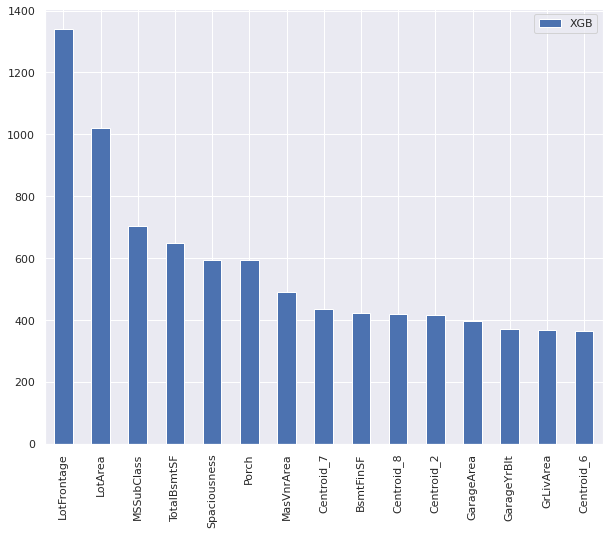

In [75]:
feature_imporances = xg_model.get_booster().get_score(importance_type='weight')
importances = pd.DataFrame({"XGB":feature_imporances.values()}, index = feature_imporances.keys())
importances.sort_values("XGB", ascending = False, inplace=True)
importances[:15].plot.bar()

## ADA Boost

In [76]:
# %%time # 7min
# ada_param_grid = {'learning_rate': [0.5, 1],'n_estimators': [500, 750], 'base_estimator__max_features':['auto','sqrt'] }
# grid_ada = GridSearchCV(AdaBoostRegressor(random_state = 13, base_estimator=DecisionTreeRegressor()), ada_param_grid, cv=4)
# grid_ada.fit(X, y)
# print(grid_ada.best_estimator_)
# print(grid_ada.best_params_)
# ada_score = grid_ada.best_score_
# print(ada_score) 

In [77]:
%%time
ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_features='sqrt'),learning_rate=1, n_estimators=500, random_state=13).fit(X_train,y_train)
# ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_features='sqrt'),learning_rate=1, n_estimators=500, random_state=13).fit(X_train,y_train) #v1
# ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_features='sqrt'),learning_rate=0.5, n_estimators=500, random_state=13).fit(X_train,y_train) #v2

CPU times: user 3.17 s, sys: 17.8 ms, total: 3.19 s
Wall time: 3.18 s


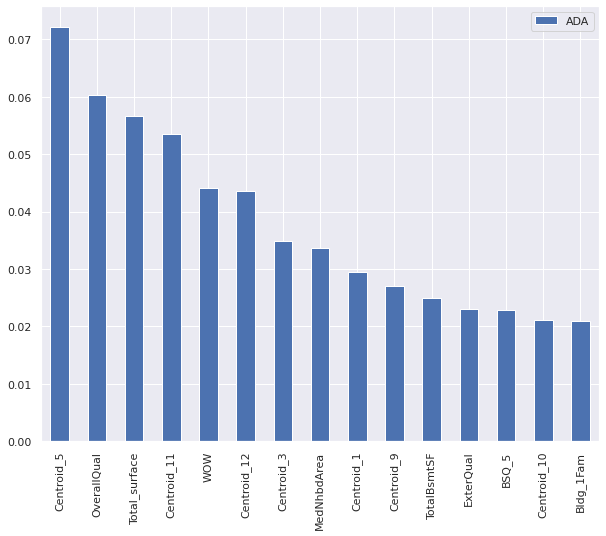

In [78]:
features = {}
for feature, importance in zip(X_train.columns, ada_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"ADA":features})
importances.sort_values("ADA", ascending = False, inplace=True)
importances[:15].plot.bar();

## Extra Trees

In [79]:
# %%time #1min
# param_grid = {'n_estimators': [500, 750], 'max_depth': [20, None], 'bootstrap': [False, True], 'max_samples': [0.8, 1], 'max_features':['auto']}
# grid_ET = GridSearchCV(ExtraTreesRegressor(random_state = 13, n_jobs=-1), param_grid, cv=4)
# grid_ET.fit(X, y)
# print(grid_ET.best_estimator_)
# print(grid_ET.best_params_)
# ET_score = grid_ET.best_score_
# print(ET_score)

In [80]:
%%time
ET_model = ExtraTreesRegressor(max_samples=0.8, n_estimators=500, bootstrap=True, random_state=13, n_jobs=-1).fit(X_train,y_train)
# ET_model = ExtraTreesRegressor(max_samples=0.9, n_estimators=750, max_depth=20, bootstrap=True, max_features="auto", \
#                                                                     random_state=13, n_jobs=-1).fit(X_train,y_train) #v1
# ET_model = ExtraTreesRegressor(max_samples=0.8, n_estimators=500, max_depth=None, bootstrap=True, max_features="auto", \
#                                                                     random_state=13, n_jobs=-1).fit(X_train,y_train) #v2

CPU times: user 9.96 s, sys: 193 ms, total: 10.2 s
Wall time: 3.25 s


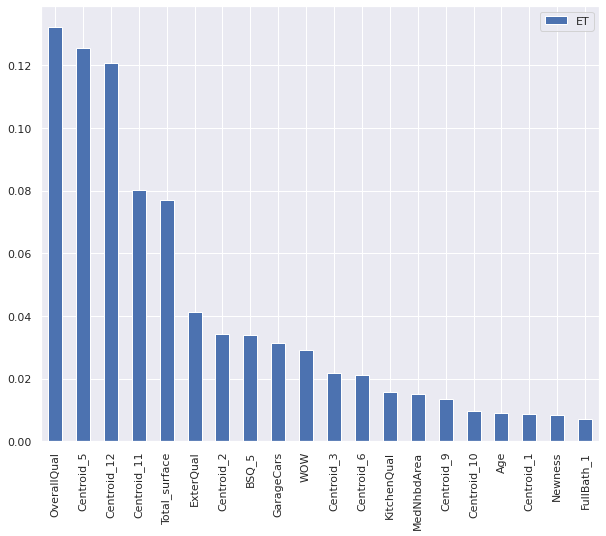

In [81]:
features = {}
for feature, importance in zip(X_train.columns, ET_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"ET":features})
importances.sort_values("ET", ascending = False, inplace=True)
importances[:20].plot.bar();

## GradientBoostingRegressor

In [82]:
# %%time # 32min
# #param_grid = {'n_estimators': [2000, 3000], 'max_depth': [4, 10, None], 'min_samples_leaf': [5,15], 'min_samples_split': [5, 10],'learning_rate': [0.05, 0.1]}
# #param_grid = {'n_estimators': [3000], 'max_depth': [4,10],'learning_rate': [0.05], 'max_features':['auto','sqrt',0.9, 0.8, 0.75]}
# param_grid = {'n_estimators': [3000], 'max_depth': [4,10],'learning_rate': [0.05], 'max_features':['auto','sqrt', 0.8]}
# #grid_GB = GridSearchCV(GradientBoostingRegressor(random_state = 13, loss='huber',  max_features='sqrt'), param_grid, cv=3)
# grid_GB = GridSearchCV(GradientBoostingRegressor(random_state = 13, loss='huber'), param_grid, cv=3)
# grid_GB.fit(X, y)
# print(grid_GB.best_estimator_)
# print(grid_GB.best_params_)
# GB_score = grid_GB.best_score_
# print(GB_score) 

In [83]:
%%time
GBoost_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', 
                                         random_state =13).fit(X_train,y_train)
# GBoost_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', 
#                                          random_state =13).fit(X_train,y_train) # v1
# GBoost_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', 
#                                          random_state =13).fit(X_train,y_train) # v2

CPU times: user 15.7 s, sys: 2.98 ms, total: 15.7 s
Wall time: 15.7 s


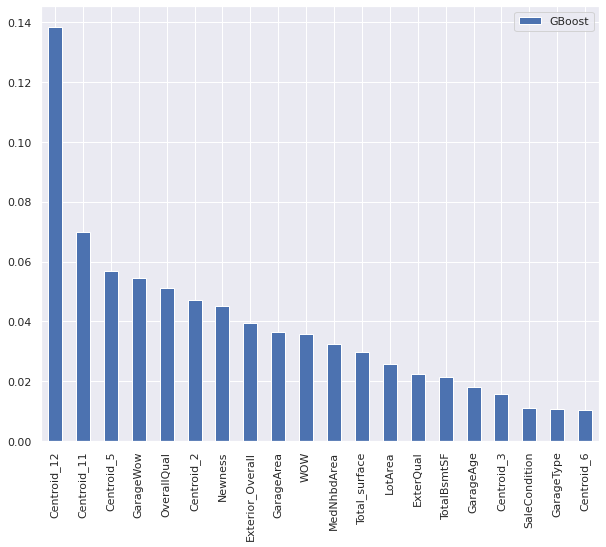

In [84]:
features = {}
for feature, importance in zip(X_train.columns, GBoost_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"GBoost":features})
importances.sort_values("GBoost", ascending = False, inplace=True)
importances[:20].plot.bar();

## LGBM

In [85]:
%%time
np.random.seed(13)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, bagging_seed=9,min_data_in_leaf =6, 
                              min_sum_hessian_in_leaf = 11).fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
CPU times: user 2.09 s, sys: 34.5 ms, total: 2.13 s
Wall time: 587 ms


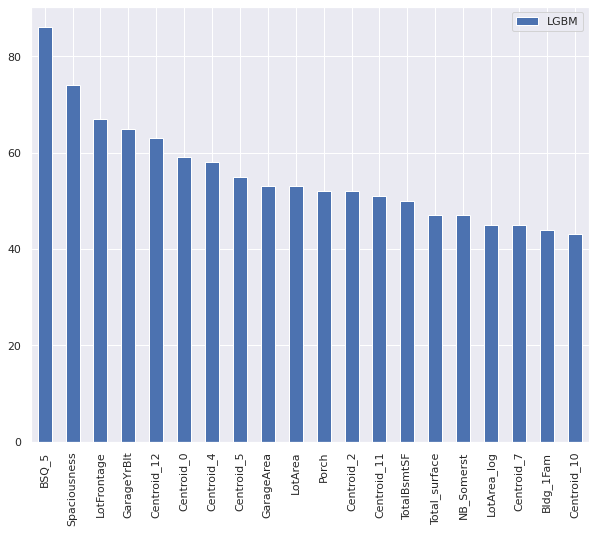

In [86]:
features = {}
for feature, importance in zip(X_train.columns, model_lgb.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"LGBM":features})
importances.sort_values("LGBM", ascending = False, inplace=True)
importances[:20].plot.bar();

## KRR


In [87]:
# %%time   # 8s
# # param_grid = {'kernel': ['linear', 'polynomial'], 'degree': [1,2,3], 'alpha':[0.1, 0.5, 1],'coef0': [1,2]}
# param_grid = {'alpha': [0.1, 0.5, 1], 'kernel': ['polynomial'], 'degree': [1, 2]}
# grid_KRR = GridSearchCV(KernelRidge(coef0=2.5), param_grid, cv=4)
# grid_KRR.fit(X, y)
# print(grid_KRR.best_estimator_)
# print(grid_KRR.best_params_)
# KRR_score = grid_KRR.best_score_
# print(KRR_score) 

In [88]:
%%time
KRR_model = KernelRidge(alpha=0.1, degree=1, kernel='polynomial').fit(X_train,y_train)
# KRR_model = KernelRidge(alpha=0.5, degree=1, kernel='polynomial').fit(X_train,y_train) #v1
# KRR_model = KernelRidge(alpha=0.1, degree=1, kernel='polynomial').fit(X_train,y_train) #v2

CPU times: user 153 ms, sys: 143 ms, total: 296 ms
Wall time: 95.8 ms


## SVR

In [89]:
# %%time # 5 min 
# param_grid = {'kernel': ['linear'],  'C':[1000, 10**4, 10**5], 'gamma': ['scale']}
# grid_SVR = GridSearchCV(SVR(), param_grid, cv=4)
# grid_SVR.fit(X, y)
# print(grid_SVR.best_estimator_)
# print(grid_SVR.best_params_)
# SVR_score = grid_SVR.best_score_
# print(SVR_score) 

In [90]:
# %%time
SVR_model = SVR(C=1000, kernel='linear').fit(X_train,y_train) 
# SVR_model = SVR(C=1000, kernel='linear', gamma="scale").fit(X_train,y_train) #v1
# SVR_model = SVR(C=1000, kernel='linear', gamma="scale").fit(X_train,y_train) #v2

## Scores

In [91]:
#10 models (no SVR)
models = [RF_model, ridge_model, elastic_model, xg_model, ada_model,ET_model, GBoost_model, model_lgb, KRR_model, lasso_model]
model_names = ["RF", 'Ridge', "Elastic", "XGB", "ADA", "ET", "GBoost", "LGBM", "KRR", "Lasso"]

#9 models (no SVR, Lasso)
# models = [RF_model, ridge_model, elastic_model, xg_model, ada_model,ET_model, GBoost_model, model_lgb, KRR_model]
# model_names = ["RF", 'Ridge', "Elastic", "XGB", "ADA", "ET", "GBoost", "LGBM", "KRR"]

In [92]:
%%time
scoreList = []
for i, m in enumerate(models):
    score = [model_names[i]]
    score.append(m.score(X_train,y_train))
    score.append(m.score(X_test,y_test))
    score.append(np.sqrt(mean_squared_error(np.log(y_train),np.log(m.predict(X_train)))))
    score.append(np.sqrt(mean_squared_error(np.log(y_test),np.log(m.predict(X_test)))))
    scoreList.append(score)

scores = pd.DataFrame(scoreList, columns = ['model', 'train_score', 'test_score', 'train_RMSE', 'test_RMSE'])
scores['overfit'] = scores.test_RMSE - scores.train_RMSE
scores.sort_values(['test_RMSE'], ascending = True, inplace = True)
scores.reset_index(drop=True, inplace=True)
scores

CPU times: user 3.73 s, sys: 594 ms, total: 4.32 s
Wall time: 3.14 s


model  train_score  test_score  train_RMSE  test_RMSE   overfit
0       ET     0.981020    0.930344    0.057790   0.120746  0.062956
1      ADA     0.999778    0.917580    0.008215   0.123095  0.114880
2   GBoost     0.992259    0.922886    0.031640   0.124499  0.092859
3     LGBM     0.982616    0.920562    0.066436   0.126017  0.059581
4    Lasso     0.939014    0.924795    0.107001   0.126771  0.019770
5      XGB     0.999954    0.907512    0.003969   0.128357  0.124388
6       RF     0.984896    0.901553    0.049490   0.129213  0.079723
7      KRR     0.940151    0.923164    0.107435   0.129361  0.021926
8  Elastic     0.941143    0.922753    0.108045   0.129967  0.021922
9    Ridge     0.941807    0.922154    0.108643   0.130711  0.022069

<AxesSubplot:xlabel='model', ylabel='test_RMSE'>

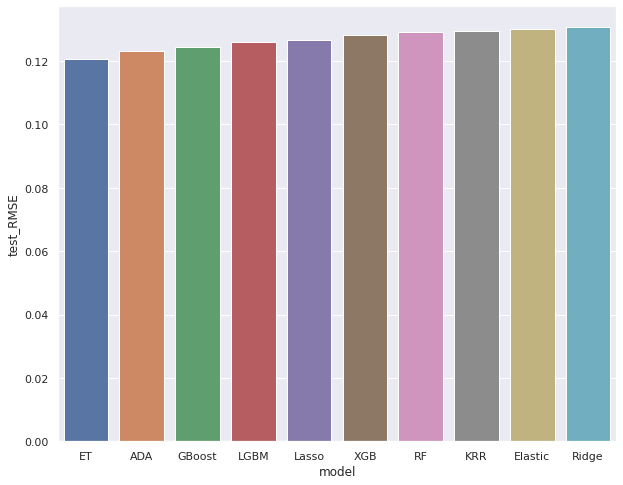

In [93]:
sns.barplot(data = scores, x="model", y="test_RMSE")

## Observe TRAIN predictions 

CPU times: user 2.74 s, sys: 448 ms, total: 3.18 s
Wall time: 2.08 s


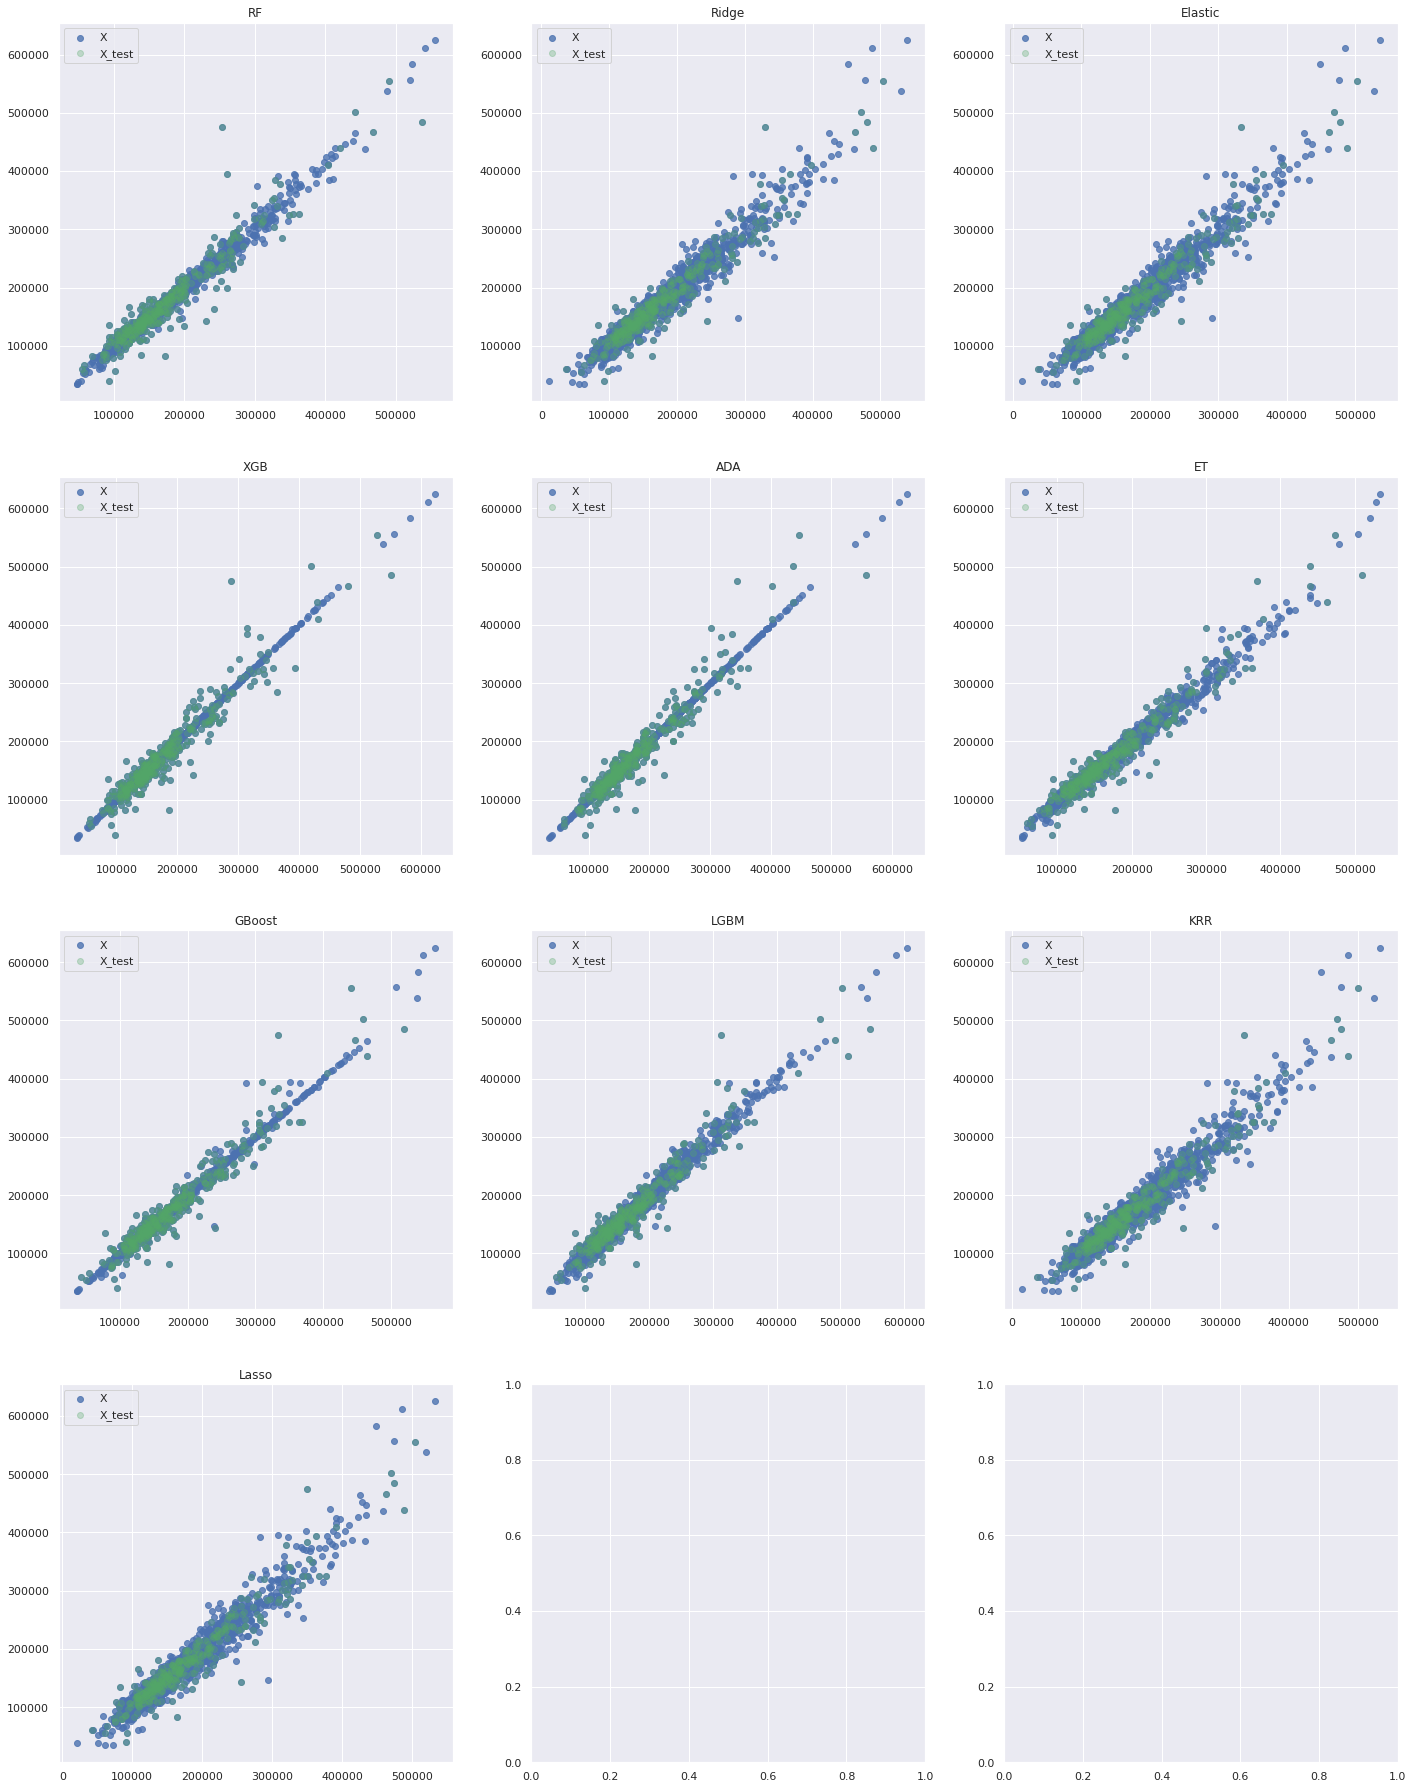

In [94]:
%%time
n_cols = 3
col_width = 8
n_rows = round(len(models) / n_cols + 0.49)
fig, axs = plt.subplots(nrows = n_rows, ncols=n_cols, figsize=(col_width * n_cols, n_rows * col_width))

for i in range(len(models)):
    axs[i//n_cols, i%n_cols].scatter(models[i].predict(X), y, alpha = 0.8, color="b", label = "X")
    axs[i//n_cols, i%n_cols].scatter(models[i].predict(X_test), y_test, alpha = 0.3, color="g", label = "X_test")
    axs[i//n_cols, i%n_cols].set_title(model_names[i])
    axs[i//n_cols, i%n_cols].legend()

In [95]:
train_dict = {"Id": train.Id}
for i, m in enumerate(models):
    train_dict[model_names[i]] = m.predict(X)

all_train = pd.DataFrame(train_dict)
all_train['Voting'] = all_train[model_names].mean(axis=1)
all_train['True'] = y
all_train['DIFF'] = all_train['True'] - all_train.Voting

all_train.head(10)

Id          RF          Ridge        Elastic            XGB       ADA  \
0   1  199073.448  206985.527994  207095.682728  200676.062500  207500.0   
1   2  182269.518  196716.548918  196395.789489  181734.765625  181500.0   
2   3  222050.112  209936.994015  209815.691236  223579.500000  223500.0   
3   4  163263.572  172994.578968  173333.141542  175436.437500  170000.0   
4   5  267912.476  281665.820953  282146.577722  276755.937500  271000.0   
5   6  165853.664  165089.944718  164114.570648  164123.000000  164500.0   
6   7  301163.860  297291.512805  298517.912318  306188.718750  307000.0   
7   8  214851.282  231731.084459  231718.135395  199762.765625  200000.0   
8   9  134849.290  131280.081160  131839.110971  129887.328125  129900.0   
9  10  120187.498  139110.950592  139575.191589  118137.585938  118000.0   

           ET         GBoost           LGBM            KRR          Lasso  \
0  208565.132  204315.659150  202173.331435  207058.078926  207722.165281   
1  181929.100  181868.398879  181545.400275  196120.286736  196469.559901   
2  222195.116  224269.513704  221232.598599  209851.701561  210296.684450   
3  173520.934  178744.472090  180110.635479  173665.777901  174510.090123   
4  275560.710  296947.157817  284845.258529  283083.109356  282597.762545   
5  161192.174  154600.693524  153181.675662  163660.273102  163268.080958   
6  297294.410  305708.599576  295502.316104  299403.866673  298845.254442   
7  217839.164  199803.533939  208554.779163  231558.856010  228534.471799   
8  138784.120  131031.624867  138795.369033  132648.860062  134836.100759   
9  120958.620  119538.846407  122758.030228  139792.374187  135315.444818   

          Voting    True          DIFF  
0  205116.508801  208500   3383.491199  
1  187654.936782  181500  -6154.936782  
2  217672.791157  223500   5827.208843  
3  173557.963960  140000 -33557.963960  
4  280251.481042  250000 -30251.481042  
5  161958.407661  143000 -18958.407661  
6  300691.645067  307000   6308.354933  
7  216435.407239  200000 -16435.407239  
8  133385.188498  129900  -3485.188498  
9  127337.454176  118000  -9337.454176

In [96]:
checkN = 20
all_train.loc[np.abs(all_train.DIFF).nlargest(checkN).index]

Id          RF          Ridge        Elastic            XGB       ADA  \
185    186  253076.052  329974.380788  332650.099800  287865.593750  345000.0   
587    589  230900.976  245006.203344  245473.670499  225552.453125  223500.0   
631    633  172890.314  163865.018478  163288.195477  185725.625000  175500.0   
1320  1325  196251.308  290538.228960  291618.081320  149913.234375  147000.0   
896    899  541868.230  487372.937242  485903.202911  611350.875000  611657.0   
687    689  332983.350  283036.108487  282664.991339  389149.500000  392000.0   
801    804  523895.138  451700.870245  449505.760062  582694.625000  582933.0   
378    379  260790.904  366202.659246  365831.140918  315186.843750  301500.0   
440    441  490465.314  504207.773642  502575.812520  528673.187500  446261.0   
1167  1170  555540.746  539724.802882  536706.166964  623112.187500  625000.0   
30      31   93241.916   92849.369213   91779.080624   97644.085938   94000.0   
1208  1212  242359.342  209133.620075  208088.230837  221186.343750  208300.0   
712    715  180016.206  181593.225729  181163.166988  173891.328125  181500.0   
142    143  120890.862  108679.486996  107747.765063  115033.664062  124900.0   
1264  1268  335747.736  322891.871157  321242.373156  336419.093750  318061.0   
580    582  282160.946  343342.765872  343071.025328  253256.640625  253293.0   
772    775  355498.172  310207.585400  310038.467286  394248.093750  395000.0   
1449  1454  138750.928  130139.448038  130616.313724  129939.523438  145000.0   
968    971   93425.264   83046.399552   82948.691331   86170.000000   91500.0   
1044  1047  520485.370  476935.174609  476296.040073  556528.187500  556581.0   

              ET         GBoost           LGBM            KRR          Lasso  \
185   368705.434  332961.539810  313252.586727  334792.166367  350328.838069   
587   223319.846  240031.315937  227724.790772  246678.615891  254841.441947   
631   177554.292  171804.491214  178959.004534  163596.046543  164478.417452   
1320  206122.088  239359.330611  209167.073872  293126.166271  293583.354603   
896   528024.972  548481.477874  587344.313623  484694.005062  486361.873194   
687   321411.550  285351.613235  326149.962615  282227.264904  282489.572129   
801   520073.174  540476.273993  555894.455319  447016.411697  448910.047634   
378   299578.722  309084.154344  306593.213355  367092.248783  363328.981140   
440   473364.114  440626.714920  502411.686546  500380.700661  503683.772961   
1167  533902.598  565052.104192  604925.944105  531526.306992  532544.127125   
30     93471.632   95042.196244   99019.058171   90328.697351   90815.235103   
1208  233355.388  216378.923756  214646.555193  208520.079151  207143.518571   
712   183191.004  183286.625527  184385.070207  181739.233316  185405.150862   
142   120611.482  123483.101888  119719.663153  107860.784863  107728.645744   
1264  332599.258  327693.794709  349105.178446  320008.619694  319223.653597   
580   296204.200  297335.852209  275993.416505  343523.122932  343812.902205   
772   351354.180  350438.118715  367054.507195  310005.631691  307813.871049   
1449  136575.588  139749.903612  125854.720217  130881.803072  132528.002500   
968    94384.996   78102.830462   83444.631731   82094.824039   82648.345884   
1044  504761.518  507224.296538  532748.484994  474717.786415  473696.539052   

             Voting    True           DIFF  
185   324860.669131  475000  150139.330869  
587   236302.931351  143000  -93302.931351  
631   171766.140470   82500  -89266.140470  
1320  231667.886601  147000  -84667.886601  
896   537305.888691  611657   74351.111309  
687   317746.391271  392000   74253.608729  
801   510309.975595  582933   72623.024405  
378   325518.886754  394432   68913.113246  
440   489265.007675  555000   65734.992325  
1167  564803.498376  625000   60196.501624  
30     93819.127064   40000  -53819.127064  
1208  216911.200133  164000  -52911.200133  
712   181617.101076  130500  -51117.1010

In [97]:
print("Voting RMSE:", np.sqrt(mean_squared_error(np.log(y),np.log(all_train['Voting']))))

Voting RMSE: 0.07819750645218157


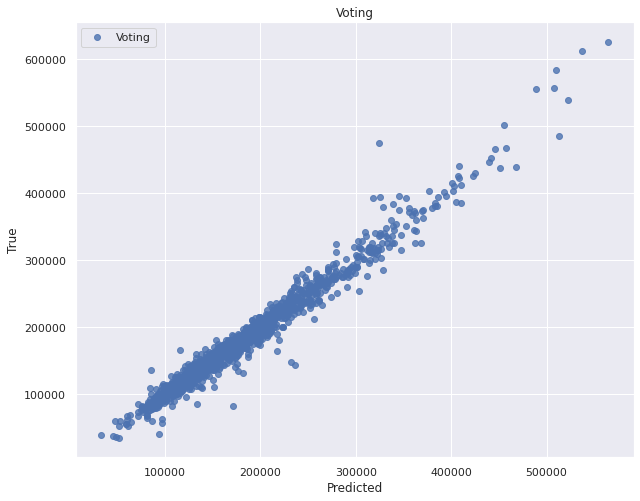

In [98]:
plt.scatter(all_train['Voting'], y, alpha = 0.8, color='b', label = 'Voting')
plt.title("Voting")
plt.legend()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [99]:
colors = ["red", 'blue', "yellow", "aquamarine", "coral", "magenta", "gold", "hotpink", "teal", "aqua", "peru"]
colors = colors[:len(models)]
colors.append('lawngreen') #Voting
colors.append('black') #True

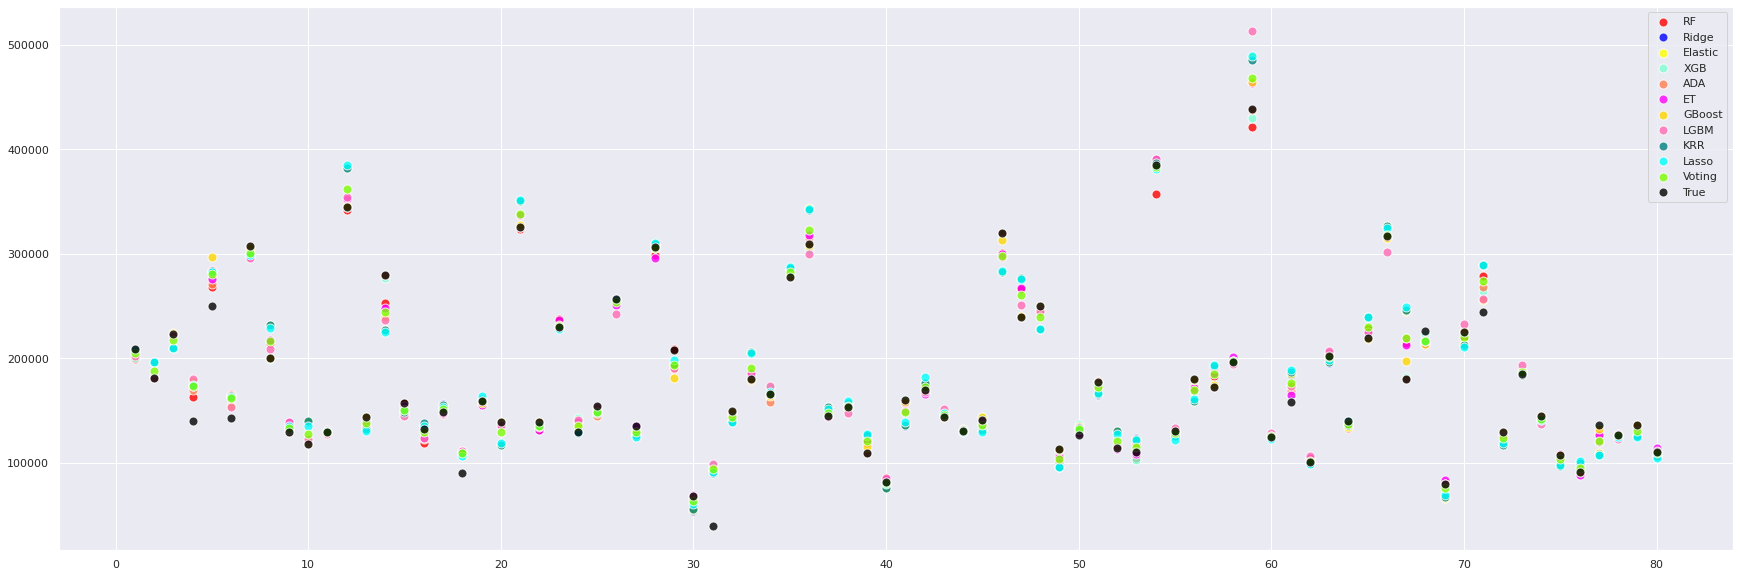

In [100]:
disp = 80
fig, ax = plt.subplots(figsize=(30,10))
for i, col in enumerate(all_train.columns[1:-1].tolist()):
    plt.scatter(x = all_train[:disp].Id, y= all_train[:disp][col], alpha=0.8, c = colors[i], edgecolors= "white", s=80)
    plt.legend(all_train.columns[1:].tolist())

plt.show()

## Predict

### Observe TEST predictions

In [101]:
test_dict = {"Id": HouseIds}
for i, m in enumerate(models):
    test_dict[model_names[i]] = m.predict(test)

all_test = pd.DataFrame(test_dict)
all_test['Voting'] = all_test[model_names].mean(axis=1)
all_test.head(10)

Id          RF          Ridge        Elastic            XGB       ADA  \
0  1461  132012.020  120444.105761  119545.921868  129400.140625  129000.0   
1  1462  161926.750  167429.842107  166686.261379  165021.609375  157500.0   
2  1463  188159.372  186583.348429  185406.825834  196162.921875  181000.0   
3  1464  195290.572  194491.053460  193070.989416  198018.593750  189000.0   
4  1465  185390.718  191954.624781  191530.716135  158035.468750  182000.0   
5  1466  175883.702  170420.368488  169383.815452  171762.453125  178000.0   
6  1467  186303.624  176072.804079  175525.237433  184402.984375  179665.0   
7  1468  170528.174  161845.651784  160915.284134  167878.625000  173000.0   
8  1469  178505.178  197162.483736  196076.164225  182881.625000  179900.0   
9  1470  123450.606  128196.603481  126757.674989  122390.757812  124000.0   

           ET         GBoost           LGBM            KRR          Lasso  \
0  124115.536  127292.818826  126810.009953  119252.022312  117712.150194   
1  160202.482  158346.797978  161657.375369  166836.116512  167109.967011   
2  181752.012  182992.653822  186636.028103  184995.983936  184577.275471   
3  191942.690  194241.526047  201795.138171  192562.795406  195550.052823   
4  190431.818  182339.775481  177251.465914  191790.921459  193099.615683   
5  177084.846  174841.110446  170775.792746  169110.157505  168649.743962   
6  179914.850  176122.011184  171438.874101  175946.147018  178009.168588   
7  171369.284  171488.102851  165636.585790  160849.269890  161253.634633   
8  180168.044  174235.253668  186164.290146  195597.437004  197577.596323   
9  125058.244  129182.563830  131678.089114  125776.839703  122680.277284   

          Voting  
0  124558.472554  
1  163271.720173  
2  185826.642147  
3  194596.341107  
4  184382.512420  
5  172591.198972  
6  178340.070078  
7  166476.461208  
8  186826.807210  
9  125917.165621

In [102]:
output = pd.DataFrame({"Id": HouseIds, "SalePrice": all_test['Voting']})
output.head(10)

Id      SalePrice
0  1461  124558.472554
1  1462  163271.720173
2  1463  185826.642147
3  1464  194596.341107
4  1465  184382.512420
5  1466  172591.198972
6  1467  178340.070078
7  1468  166476.461208
8  1469  186826.807210
9  1470  125917.165621

In [103]:
output.to_csv('submission.csv', index=False)
print("Submission done.")

Submission done.


In [104]:
end_time = time.time()
print("Notebook run time: {:.1f} seconds. Finished at {}".format(end_time - start_time, datetime.now()) )

Notebook run time: 193.3 seconds. Finished at 2022-06-11 12:55:24.329204
